In [ ]:
# This will fully restart the Colab runtime
import os
os.kill(os.getpid(), 9)

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import binary_erosion
import sys
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import os
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from torch.autograd import Variable
import os
import time
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop
import torchvision.transforms.functional as TF
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomCrop
from sklearn.model_selection import train_test_split

print(torch.__version__)

2.6.0+cu124


In [ ]:
# Mount Drive. When running this there will be a pop-up you have to confirm
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# Copy data from Drive
!cp -r "/content/drive/MyDrive/AAMI_Data_trin/Train" "/content/Train"
!cp -r "/content/drive/MyDrive/AAMI_Data_trin/Test" "/content/Test"

Data Exploration

In [ ]:
#Check the number of images from each device

# Base paths for images
base_image_path_train = '/content/Train/1.0_Original_Images'
base_label_path_train = '/content/Train/4.0_OD_CO_Fusion_Images'
base_metrics_path_train = '/content/Train/6.0_Glaucoma_Decision'

base_image_path_test = '/content/Test/1.0_Original_Fundus_Images'
base_label_path_test = '/content/Test/4.0_OD_CO_Fusion_Images'
base_metrics_path_test = '/content/Test/6.0_Glaucoma_Decision'

# Device subfolders
devices = ['Remidio', 'Forus', 'Bosch']

Rem_im_Trn_path = os.path.join(base_image_path_train, "Remidio")
Rem_lab_Trn_path = os.path.join(base_label_path_train, "Remidio", "STAPLE")
Rem_Met_Trn_path = os.path.join(base_metrics_path_train, "Mean", "Remidio.csv")
Rem_Glauc_Trn_path = os.path.join(base_metrics_path_train, "Glaucoma_Decision_Comparison_Remidio_majority.csv")

Rem_im_Test_path = os.path.join(base_image_path_test, "Remidio")
Rem_lab_Test_path = os.path.join(base_label_path_test, "Remidio", "STAPLE")
Rem_Met_Test_path = os.path.join(base_metrics_path_test, "Mean", "Remidio.csv")
Rem_Glauc_Test_path = os.path.join(base_metrics_path_test, "Glaucoma_Decision_Comparison_Remidio_majority.csv")

Forus_im_Trn_path = os.path.join(base_image_path_train, "Forus")
Forus_lab_Trn_path = os.path.join(base_label_path_train, "Forus", "STAPLE")
Forus_Met_Trn_path = os.path.join(base_metrics_path_train, "Mean", "Forus.csv")
Forus_Glauc_Trn_path = os.path.join(base_metrics_path_train, "Glaucoma_Decision_Comparison_Forus_majority.csv")

Forus_im_Test_path = os.path.join(base_image_path_test, "Forus")
Forus_lab_Test_path = os.path.join(base_label_path_test, "Forus", "STAPLE")
Forus_Met_Test_path = os.path.join(base_metrics_path_test, "Mean", "Forus.csv")
Forus_Glauc_Test_path = os.path.join(base_metrics_path_test, "Glaucoma_Decision_Comparison_Forus_majority.csv")

Bosch_im_Trn_path = os.path.join(base_image_path_train, "Bosch")
Bosch_lab_Trn_path = os.path.join(base_label_path_train, "Bosch", "STAPLE")
Bosch_Met_Trn_path = os.path.join(base_metrics_path_train, "Mean", "Bosch.csv")
Bosch_Glauc_Trn_path = os.path.join(base_metrics_path_train, "Glaucoma_Decision_Comparison_Bosch_majority.csv")

Bosch_im_Test_path = os.path.join(base_image_path_test, "Bosch")
Bosch_lab_Test_path = os.path.join(base_label_path_test, "Bosch", "STAPLE")
Bosch_Met_Test_path = os.path.join(base_metrics_path_test, "Mean", "Bosch.csv")
Bosch_Glauc_Test_path = os.path.join(base_metrics_path_test, "Glaucoma_Decision_Comparison_Bosch_majority.csv")

im_paths = [Rem_im_Trn_path, Forus_im_Trn_path, Bosch_im_Trn_path]
lab_paths = [Rem_lab_Trn_path, Forus_lab_Trn_path, Bosch_lab_Trn_path]

num_images = 0
num_labels = 0
# Collect images for each device
for i, device in enumerate(devices):
    images = sorted(os.listdir(im_paths[i]))
    labels = sorted(os.listdir(lab_paths[i]))
    num_images += len(images)
    num_labels += len(labels)
    print(f"{device} - {len(images)} images, {len(labels)} labels")

print("Total combined images:", num_images)
print("Total combined labels:", num_labels)

Remidio - 810 images, 810 labels
Forus - 95 images, 95 labels
Bosch - 104 images, 104 labels
Total combined images: 1009
Total combined labels: 1009


Processing /content/Train/4.0_OD_CO_Fusion_Images/Forus/STAPLE
Processing /content/Train/4.0_OD_CO_Fusion_Images/Bosch/STAPLE
Processing /content/Train/4.0_OD_CO_Fusion_Images/Remidio/STAPLE


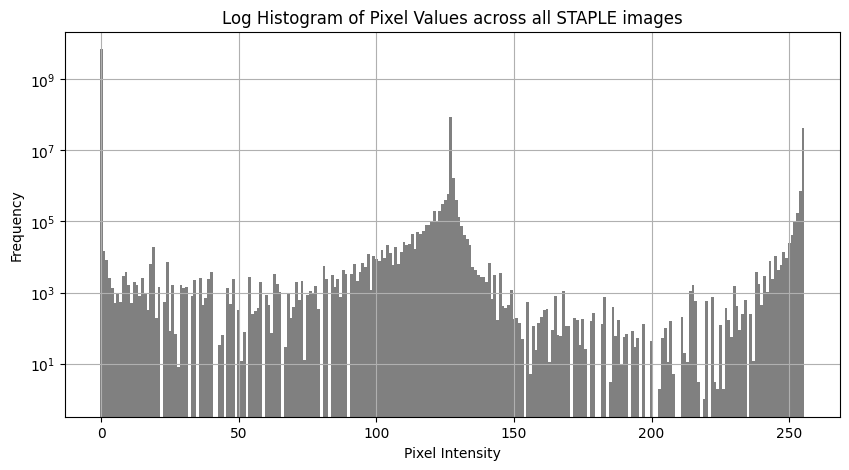

In [ ]:
#Inspect the frequency of each intensity in the STAPLE images
# Main directory containing folders
base_path = '/content/Train/4.0_OD_CO_Fusion_Images'

# Initialize a histogram array for pixel values [0-255]
pixel_histogram = np.zeros(256, dtype=np.int64)

# List of subfolders
devices = ['Forus', 'Bosch', 'Remidio']

# Loop over each device folder
for device in devices:
    staple_folder = os.path.join(base_path, device, 'STAPLE')
    print(f"Processing {staple_folder}")

    # Loop through all PNG images in the STAPLE subfolder
    for filename in os.listdir(staple_folder):
        if filename.lower().endswith('.png'):
            image_path = os.path.join(staple_folder, filename)
            image = Image.open(image_path)  # Grayscale
            img_array = np.array(image).flatten()

            # Count pixel occurrences using numpy's bincount
            counts = np.bincount(img_array, minlength=256)

            # Add to histogram
            pixel_histogram += counts

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(256), pixel_histogram, color='gray', width=1.0)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.yscale('log')  # Logarithmic scale for better visualization
plt.title('Log Histogram of Pixel Values across all STAPLE images')
plt.grid(True)
plt.show()

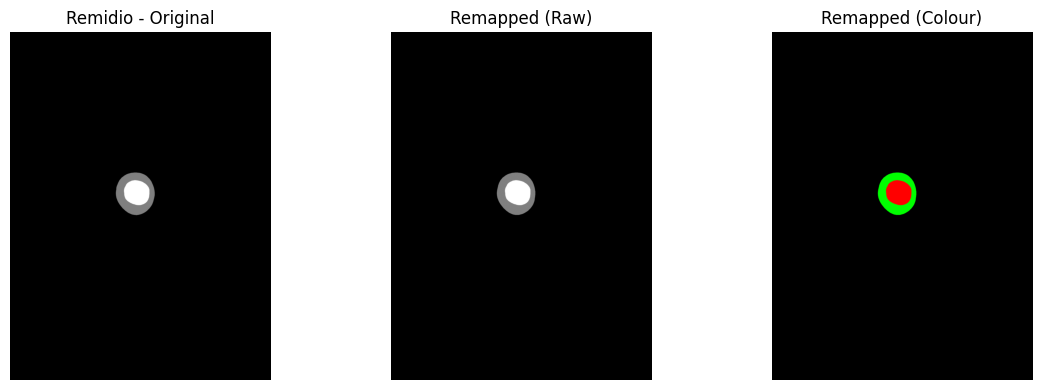

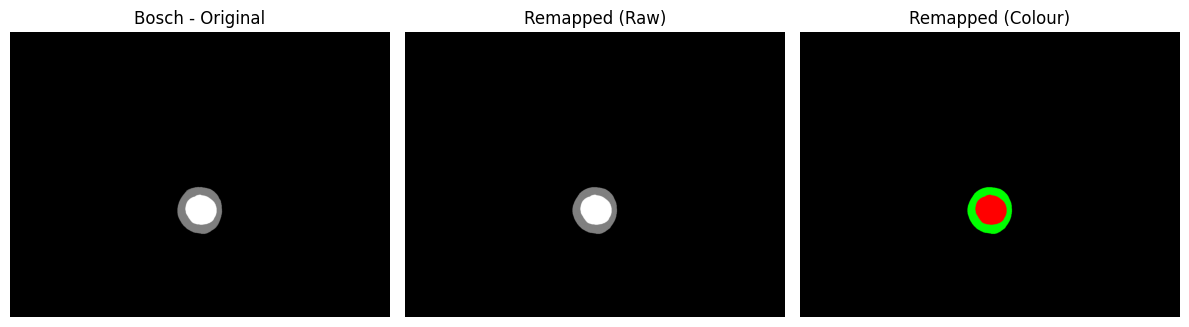

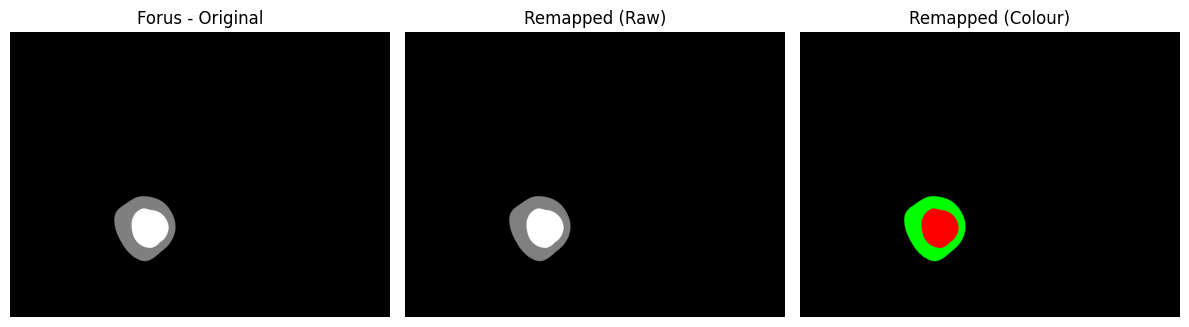

In [ ]:

'''
Remapping labels to 3 classes:
- 0: background
- 1: disc (126–192)
- 2: cup (193–255) as seen on the previous pixel exploration
'''
path_labels = 'Train/4.0_OD_CO_Fusion_Images/Remidio/STAPLE'
labels = sorted(os.listdir(path_labels))

path_labels_2 = 'Train/4.0_OD_CO_Fusion_Images/Bosch/STAPLE'
labels_2 = sorted(os.listdir(path_labels_2))

path_labels_3 = 'Train/4.0_OD_CO_Fusion_Images/Forus/STAPLE'
labels_3 = sorted(os.listdir(path_labels_3))

def remap_labels(label_image):
    """
    Convert grayscale label to class index map:
    - 0: background
    - 1: disc (126–192)
    - 2: cup (193–255)
    """
    gray = cv2.cvtColor(label_image, cv2.COLOR_RGB2GRAY)
    new_label = np.zeros_like(gray)
    new_label[(gray >= 126) & (gray <= 192)] = 1
    new_label[(gray >= 193) & (gray <= 255)] = 2
    return new_label


def colorize_mask(mask):
    colors = {
        0: [0, 0, 0],       # background
        1: [0, 255, 0],     # disc (green)
        2: [255, 0, 0],     # cup (red)
    }
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for k, v in colors.items():
        color_mask[mask == k] = v
    return color_mask

def test_remap_on_label(path, filename, title=""):
    img = cv2.imread(os.path.join(path, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    remapped = remap_labels(img)
    color = colorize_mask(remapped)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"{title} - Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(remapped, cmap='gray')
    plt.title("Remapped (Raw)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(color)
    plt.title("Remapped (Colour)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Run it manually
test_remap_on_label(path_labels, labels[0], "Remidio")
test_remap_on_label(path_labels_2, labels_2[0], "Bosch")
test_remap_on_label(path_labels_3, labels_3[0], "Forus")

### Task 1

In [ ]:
# Baseline architecture written by XXX
# Define the necessary transformations - important to ensure the images from
# different folders are the same size and format
# Resize shortest side to 256, then center crop to get a 256x256 square
transform = transforms.Compose([
    transforms.Resize(256),         # shortest side becomes 256
    transforms.CenterCrop(256),     # crops a centered 256x256 square
    transforms.ToTensor()
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, decision_csv, stats_csv, transform=None, device_name = None):
        """
        image_dir: directory with images for one device
        label_dir: directory with labels for one device
        decision_csv: path to Glaucoma_Decision_Comparison_{device}_majority.csv
        stats_csv: path to Mean/{device} CSV file
        transform: optional image transforms
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_paths = sorted(os.listdir(image_dir))
        self.label_paths = sorted(os.listdir(label_dir))
        self.transform = transform
        self.device_name = device_name

        # --- Load and preprocess decision CSV ---
        decision_df = pd.read_csv(decision_csv)
        decision_df['key'] = decision_df['Images'].apply(lambda x: x.split('.')[0])

        if 'Majority Decision' in decision_df.columns:
            decision_col = 'Majority Decision'
        elif 'Glaucoma Decision' in decision_df.columns:
            decision_col = 'Glaucoma Decision'
        else:
            raise KeyError("Neither 'Majority Decision' nor 'Glaucoma Decision' found in the CSV.")

        self.decision_dict = dict(zip(decision_df['key'], decision_df[decision_col]))

        # --- Encode decision labels ---
        self.decision_encoding = {
            'NORMAL': 0,
            'GLAUCOMA SUSPECT': 1
        }

        # --- Load and preprocess stats CSV ---
        stats_df = pd.read_csv(stats_csv)
        stats_df['key'] = stats_df['Images'].apply(lambda x: x.split('.')[0])

        # Drop non-numeric columns (except 'key')
        numeric_cols = stats_df.select_dtypes(include=[np.number]).columns.tolist()
        # Convert numeric columns to float32
        stats_df[numeric_cols] = stats_df[numeric_cols].astype(np.float32)
        self.stats_dict = {
            row['key']: row[numeric_cols].to_dict()
            for _, row in stats_df.iterrows()
        }

    def __len__(self):
        return len(self.image_paths)

    # Return just the device name and glaucoma status for a subject
    def get_group_labels(self):
      labs = []
      for img_filename in self.image_paths:
          key = img_filename.split('.')[0]
          decision = self.decision_dict[key].strip()
          lab = self.decision_encoding[decision]
          labs.append((self.device_name, lab))
      return labs

    def __getitem__(self, idx):
        # Load image and label paths
        img_filename = self.image_paths[idx]
        label_filename = self.label_paths[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        label_path = os.path.join(self.label_dir, label_filename)

        # Load and convert image + label
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('L')

        # Apply transforms
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        label_array = np.array(label)
        label_array = np.squeeze(label_array)

        # Create new label map
        label_encoded = np.zeros_like(label_array, dtype=np.uint8)
        label_encoded[(label_array >= 64/255) & (label_array < 192/255)] = 1  # disc
        label_encoded[label_array >= 192/255] = 2  # cup

        label_tensor = torch.from_numpy(label_encoded).long()

        # Build matching key by stripping everything after first '.'
        key = img_filename.split('.')[0]

        # Check keys exist in CSV-derived dictionaries
        if key not in self.decision_dict:
            raise KeyError(f"{key} not found in decision CSV.")
        if key not in self.stats_dict:
            raise KeyError(f"{key} not found in stats CSV.")

        # Fetch decision label
        decision_label_str = self.decision_dict[key].strip()
        decision_label = self.decision_encoding[decision_label_str]

        # Fetch stats
        stats_row = self.stats_dict[key]
        stats_dict = {k: float(v) for k, v in stats_row.items()}

        # Pack everything into 'info'
        info = {
            'key': key,
            'majority_decision': decision_label,
            'device': self.device_name,
            **stats_dict
        }

        return {
            'image': image,
            'label': label_tensor,
            'info': info
        }


Total number of samples in the combined dataset: 1009
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


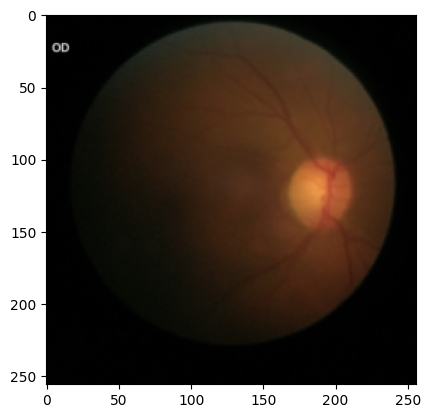

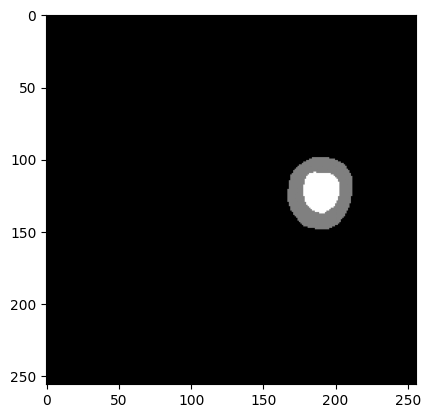

In [ ]:
#Set up the datasets for each device
remidio_dataset = CustomDataset(image_dir=Rem_im_Trn_path, label_dir=Rem_lab_Trn_path,
                                decision_csv = Rem_Glauc_Trn_path,
                                stats_csv = Rem_Met_Trn_path, transform=transform,
                                device_name = 'Remidio')
bosch_dataset = CustomDataset(image_dir = Bosch_im_Trn_path, label_dir = Bosch_lab_Trn_path,
                              decision_csv = Bosch_Glauc_Trn_path,
                              stats_csv = Bosch_Met_Trn_path, transform=transform,
                              device_name = 'Bosch')
forus_dataset = CustomDataset(image_dir = Forus_im_Trn_path, label_dir = Forus_lab_Trn_path,
                              decision_csv = Forus_Glauc_Trn_path,
                              stats_csv = Forus_Met_Trn_path, transform=transform,
                              device_name = 'Forus')
# Combine the datasets
full_dataset = ConcatDataset([remidio_dataset, bosch_dataset,forus_dataset])
print(f"Total number of samples in the combined dataset: {len(full_dataset)}")

#  train and validation sets split (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

#  training and validation sets dataloader (no use of torchio here - too complex for A 2d task)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Check a sample - uncomment to see
sample = next(iter(train_loader))
print(sample['image'].shape)  # Should be [4, 3, 256, 256] for batch size 4
print(sample['label'].shape)  # Should be [4, 1, 256, 256] for batch size 4

plt.imshow(sample['image'][3].permute(1, 2, 0))
plt.show()
plt.imshow(sample['label'][3], cmap='gray')
plt.show()



In [ ]:
'''
this ensures that the split between train/validate follows a roughly 80/20 split
'''
Remidio_train_count = 0
Bosch_train_count = 0
Forus_train_count = 0

for sample in train_dataset:
    device_name = sample["info"]["device"]
    if device_name == 'Remidio':
        Remidio_train_count += 1
    elif device_name == 'Bosch':
        Bosch_train_count += 1
    elif device_name == 'Forus':
        Forus_train_count += 1

print("Remidio Count in Train: ", Remidio_train_count)
print("Bosch Count in Train:   ", Bosch_train_count)
print("Forus Count in Train:   ", Forus_train_count)


Remidio Count in Train:  642
Bosch Count in Train:    88
Forus Count in Train:    77


In [ ]:
# initialise weights (important to restart the model every time it is instantiated)
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


# encoder
class _EncoderBN(nn.Module):
    def __init__(self, in_channels, out_channels,k ,padd , dropout=False):
        super(_EncoderBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=padd)
        self.BN1a = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=k, padding=padd)
        self.BN2a = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        x = F.leaky_relu(self.BN1a(self.conv1(x)),inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)),inplace=True)
        return x
# decoder
class _DecoderBN(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=3,padding=1)
        self.BN1a = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1)
        self.BN2a = nn.BatchNorm2d(middle_channels)
        self.convT = nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.BN1a(self.conv1(x)),inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)),inplace=True)

        return self.convT(x)

class prefinalBN(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(prefinalBN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels , out_channels, kernel_size=3, padding=1)
        self.BN1a = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.BN2a = nn.BatchNorm2d(out_channels)
        nn.InstanceNorm1d

    def forward(self, x ):

        x = F.leaky_relu(self.BN1a(self.conv1(x)),inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)),inplace=True)
        return x

In [ ]:
#unet
class ADABN(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(ADABN, self).__init__()

        self.enc1 = _EncoderBN(num_channels, 64, 5, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = _EncoderBN(64, 96, 3, 1)
        self.enc3 = _EncoderBN(96, 128, 3, 1)
        self.enc4 = _EncoderBN(128, 256, 3, 1)
        self.center = _DecoderBN(256, 512, 256)
        self.dec4 = _DecoderBN(512, 256, 128)
        self.dec3 = _DecoderBN(256, 128, 96)
        self.dec2 = _DecoderBN(96 * 2, 96, 64)
        self.dec1 = prefinalBN(128,64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        #initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = F.dropout(self.enc4(self.pool(enc3)))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([center, enc4], 1))
        dec3 = self.dec3(torch.cat([dec4, enc3], 1))
        dec2 = self.dec2(torch.cat([dec3, enc2], 1))
        dec1 = self.dec1(torch.cat([dec2, enc1], 1))

        final = self.final(dec1)
        return (final, enc1, enc2, enc3, enc4, center, dec4, dec3, dec2, dec1)

In [ ]:
# dice for each class
def dice_score_per_class(preds, targets, num_classes=3, epsilon=1e-6):
    """
        preds: [B, H, W] - predicted class indices
        targets: [B, H, W] - ground truth class indices
        num_classes: total number of classes
        epsilon: small value to avoid division by zero
    """
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = (2. * intersection + epsilon) / (union + epsilon)
        dice_scores.append(dice.item())

    return dice_scores

In [ ]:
#Hausdorff distance for each class

from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import binary_erosion

def compute_hd95(pred, target):
    """
    Compute the 95th percentile Hausdorff Distance between predicted and target masks.
    These need to be binarised masks (one for each class)

    """
    pred = np.asarray(pred, dtype=bool)
    target = np.asarray(target, dtype=bool)

    if not np.any(pred) or not np.any(target):
        return np.nan  # undefined if one mask is empty

    pred_boundary = pred ^ binary_erosion(pred)
    target_boundary = target ^ binary_erosion(target)

    pred_coords = np.argwhere(pred_boundary)
    target_coords = np.argwhere(target_boundary)

    forward_hd = directed_hausdorff(pred_coords, target_coords)[0]
    backward_hd = directed_hausdorff(target_coords, pred_coords)[0]

    return np.percentile([forward_hd, backward_hd], 95)

'''
class-based evaluation per class to assess how well the model performs per area of interest
'''
def evaluate_hd95_per_class(model, dataloader, device, num_classes=3, max_batches=None):
    model.eval()
    hd95_scores = {cls: [] for cls in range(num_classes)}

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)[0]  # assumes model returns (logits, ...)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                pred_np = preds[i].cpu().numpy()
                label_np = labels[i].cpu().numpy()

                for cls in range(num_classes):
                    pred_mask = (pred_np == cls)
                    true_mask = (label_np == cls)
                    hd = compute_hd95(pred_mask, true_mask)
                    if not np.isnan(hd):
                        hd95_scores[cls].append(hd)

            if max_batches and batch_idx + 1 >= max_batches:
                break

    avg_hd95 = {cls: np.mean(hd95_scores[cls]) if hd95_scores[cls] else np.nan for cls in range(num_classes)}



In [ ]:
# Investigate the pixel frequencies in train set to weight cross-entropy
# Initialize pixel count for 3 classes
pixel_counts = np.zeros(3)

# Loop through dataset (slow but works for small/medium sets)
for sample in train_dataset:
    label = np.array(sample['label'])  # shape: (H, W)
    for c in range(3):
        pixel_counts[c] += np.sum(label == c)

print("Pixel counts:", pixel_counts)

class_weights = 1.0 / pixel_counts
class_weights /= class_weights.sum()  # Normalise

Pixel counts: [51559391.   899292.   428869.]


In [ ]:
print(class_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights=torch.tensor(class_weights, device=device, dtype=torch.float32)

[0.00560051 0.32109595 0.67330354]


In [ ]:
'''
here we define the U-net training process, with a dice loss to monitor progress

really important: this model will shortcut and not classify the cup if
no weight is used on the criterion.
'''


class EarlyStopping: # monitoring for not overtraining
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


early_stopping = EarlyStopping(patience=5, delta=0.001)

In [ ]:
#Function train a segmentation model using the baseline architecture
def train_func(model, t_loader, v_loader, class_weights, num_epochs = 10, multi = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Model is on device: {next(model.parameters()).device}")
    criterion = nn.CrossEntropyLoss(weight = class_weights)

    val_loss_list = []
    train_loss_list = []
    optimizer = optim.Adam(model.parameters(), lr=1e-4) #Reinitializes optimizer
    initialize_weights(model)       # Reinitialises weights

    best_val_dice = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(t_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)[0]

            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss /= len(t_loader)
        train_loss_list.append(running_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total_dice = torch.zeros(3)
        with torch.no_grad():
            for batch in v_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)[0]
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                outputs = model(images)[0]  # [B, 3, H, W]
                preds = torch.argmax(outputs, dim=1)  # [B, H, W]

                dice_scores = dice_score_per_class(preds, labels)
                total_dice += torch.tensor(dice_scores)

        val_loss_list.append(val_loss / len(v_loader))
        avg_dice = total_dice / len(v_loader)
        val_dice = torch.sum(avg_dice)/3
        print(f"Avg Dice Scores - Background: {avg_dice[0]:.4f}, Disc: {avg_dice[1]:.4f}, Cup: {avg_dice[2]:.4f}") # to check the model segments the cup
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(t_loader)}, Validation Loss: {val_loss / len(v_loader)}")

        if val_dice < best_val_dice:
          best_val_dice = val_dice
          best_model_state = model.state_dict()

        '''if early_stopping(val_loss):
            print(f"Early stopping triggered at Epoch {epoch+1}")
            break'''

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model restored.")

    return model, train_loss_list, val_loss_list


In [ ]:
baseline_model = ADABN(3,3) # 3 channels since we use RGB images, also 3 output chanlles
baseline_model, train_loss_baseline, val_loss_baseline = train_func(baseline_model, train_loader, val_loader, class_weights, num_epochs = 10)

Model is on device: cuda:0


100%|██████████| 202/202 [00:16<00:00, 12.35it/s]


Avg Dice Scores - Background: 0.9798, Disc: 0.6216, Cup: 0.6823
Epoch [1/10], Training Loss: 0.0019298024937903432, Validation Loss: 0.2442538305824878


100%|██████████| 202/202 [00:15<00:00, 13.36it/s]


Avg Dice Scores - Background: 0.9931, Disc: 0.7206, Cup: 0.8473
Epoch [2/10], Training Loss: 0.0009396597662692842, Validation Loss: 0.16536527404598161


100%|██████████| 202/202 [00:15<00:00, 13.29it/s]


Avg Dice Scores - Background: 0.9972, Disc: 0.8231, Cup: 0.8835
Epoch [3/10], Training Loss: 0.0007517431186961842, Validation Loss: 0.1428980659328255


100%|██████████| 202/202 [00:14<00:00, 13.48it/s]


Avg Dice Scores - Background: 0.9964, Disc: 0.7947, Cup: 0.8732
Epoch [4/10], Training Loss: 0.0007265494427366264, Validation Loss: 0.13381850544144125


100%|██████████| 202/202 [00:14<00:00, 13.58it/s]


Avg Dice Scores - Background: 0.9971, Disc: 0.8289, Cup: 0.8698
Epoch [5/10], Training Loss: 0.0006704237931073383, Validation Loss: 0.1681438683002603


100%|██████████| 202/202 [00:15<00:00, 13.43it/s]


Avg Dice Scores - Background: 0.9971, Disc: 0.8268, Cup: 0.8939
Epoch [6/10], Training Loss: 0.0006202541720080103, Validation Loss: 0.12876377678384968


100%|██████████| 202/202 [00:14<00:00, 13.58it/s]


Avg Dice Scores - Background: 0.9965, Disc: 0.7967, Cup: 0.8982
Epoch [7/10], Training Loss: 0.0005641870971912614, Validation Loss: 0.1242404393121308


100%|██████████| 202/202 [00:15<00:00, 13.32it/s]


Avg Dice Scores - Background: 0.9964, Disc: 0.7939, Cup: 0.8710
Epoch [8/10], Training Loss: 0.0005602419716729194, Validation Loss: 0.12225745735215206


100%|██████████| 202/202 [00:15<00:00, 13.32it/s]


Avg Dice Scores - Background: 0.9838, Disc: 0.6411, Cup: 0.7160
Epoch [9/10], Training Loss: 0.000551693725944991, Validation Loss: 0.148383246625171


100%|██████████| 202/202 [00:15<00:00, 13.41it/s]


Avg Dice Scores - Background: 0.9972, Disc: 0.8257, Cup: 0.8959
Epoch [10/10], Training Loss: 0.0005170575492525905, Validation Loss: 0.11280169075026232
Best model restored.


In [ ]:
# Save the model and validation losses
torch.save(baseline_model.state_dict(), 'baseline_model.pth')
np.save('val_loss_baseline.npy', np.array(val_loss_baseline))

In [ ]:
# Instantiate test datasets for each device using the test paths
test_remidio_dataset = CustomDataset(
    image_dir=Rem_im_Test_path,
    label_dir=Rem_lab_Test_path,
    decision_csv=Rem_Glauc_Test_path,
    stats_csv=Rem_Met_Test_path,
    transform=transform,
    device_name='Remidio'
)
test_bosch_dataset = CustomDataset(
    image_dir=Bosch_im_Test_path,
    label_dir=Bosch_lab_Test_path,
    decision_csv=Bosch_Glauc_Test_path,
    stats_csv=Bosch_Met_Test_path,
    transform=transform,
    device_name='Bosch'
)
test_forus_dataset = CustomDataset(
    image_dir=Forus_im_Test_path,
    label_dir=Forus_lab_Test_path,
    decision_csv=Forus_Glauc_Test_path,
    stats_csv=Forus_Met_Test_path,
    transform=transform,
    device_name='Forus'
)
# check that the images and labels are sorted correctly
print('ordered images', test_forus_dataset.image_paths)
print('ordered labels', test_forus_dataset.label_paths)

# Combine the test datasets
test_dataset = ConcatDataset([
    test_remidio_dataset,
    test_bosch_dataset,
    test_forus_dataset
])

# Build the DataLoader for testing
test_loader_all = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=12)
test_loader_Forus = DataLoader(test_forus_dataset, batch_size=4, shuffle=False, num_workers=12)
test_loader_Bosch = DataLoader(test_bosch_dataset, batch_size=4, shuffle=False, num_workers=12)
test_loader_Remidio = DataLoader(test_remidio_dataset, batch_size=4, shuffle=False, num_workers=12)

# Check a sample from the test loader
sample = next(iter(test_loader_all))
print(sample['image'].shape)  # Should output something like [4, 3, 256, 256]
print(sample['label'].shape)  # Should output something like [4, 256, 256]


ordered images ['100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '96.png', '97.png', '98.png', '99.png']
ordered labels ['100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '96.png', '97.png', '98.png', '99.png']
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [ ]:
#Function to evaluate model with baseline architecure on test set
def evaluate_segmentation_model_df(model, test_loader, device, num_classes=3):
    model.eval()
    model.to(device)

    sample_records = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)[0]

            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                pred_i = preds[i]
                label_i = labels[i]

                # Compute Dice score
                dice_scores = dice_score_per_class(pred_i, label_i, num_classes)
                # HD95
                hd95_scores = []
                pred_np = pred_i.cpu().numpy()
                label_np = label_i.cpu().numpy()

                for cls in range(num_classes):
                    pred_mask = (pred_np == cls)
                    label_mask = (label_np == cls)
                    hd = compute_hd95(pred_mask, label_mask)
                    hd95_scores.append(hd)

                # Metadata
                image_name = batch["info"]["key"][i]
                device_name = batch["info"]["device"][i]
                status_label = batch["info"]["majority_decision"][i]
                status_str = "Glaucoma" if status_label == 1 else "Normal"

                sample_records.append({
                    "image_name": image_name,
                    "device_name": device_name,
                    "glaucoma_status": status_str,
                    "dice_background": dice_scores[0],
                    "dice_disc": dice_scores[1],
                    "dice_cup": dice_scores[2],
                    "hd95_background": hd95_scores[0],
                    "hd95_disc": hd95_scores[1],
                    "hd95_cup": hd95_scores[2],
                })

    df = pd.DataFrame(sample_records)
    return df

In [ ]:
baseline_test_df = evaluate_segmentation_model_df(baseline_model, test_loader_all, device)
baseline_test_df.to_csv('baseline_test_df.csv', index=False)

In [ ]:
#Plot dices
def plot_dice_hist(test_df):
  fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

  classes = ['dice_background', 'dice_disc', 'dice_cup']
  titles = ['Background Dice', 'Disc Dice', 'Cup Dice']
  colors = ['lightgray', 'orange', 'red']

  # Shared bins for all plots
  bins = np.linspace(0, 1, 41)  # 40 equal-width bins from 0 to 1

  for i, cls in enumerate(classes):
      axs[i].hist(test_df[cls], bins=bins, color=colors[i], edgecolor='black')
      axs[i].set_title(titles[i])
      axs[i].set_xlabel("Dice Score")
      axs[i].set_ylabel("Frequency")
      axs[i].set_xlim(0, 1)

  plt.tight_layout()
  plt.show()

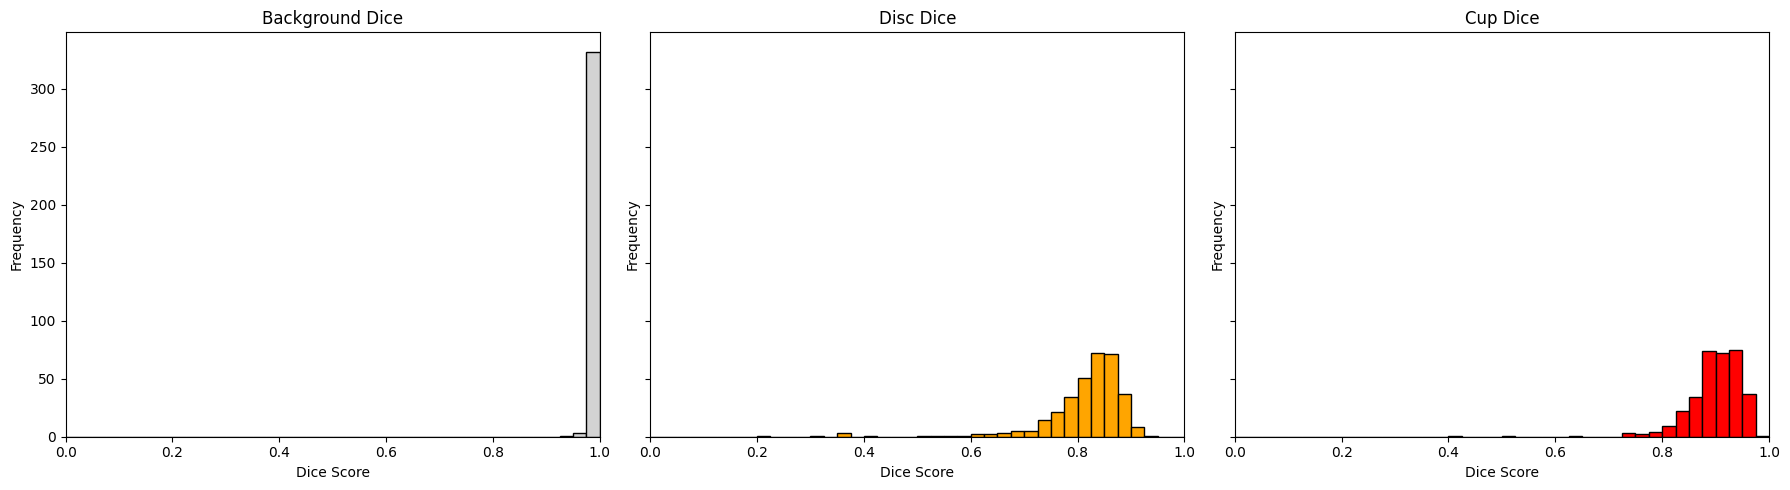

In [ ]:
plot_dice_hist(baseline_test_df)

In [ ]:
#Plot segmentations on test samples from each device
def plot_device_examples(model, tls):
    """
    Plots one example from the first batch of each test loader (one per device).

    Args:
        model: Trained PyTorch model
        tls (dict): Dictionary mapping device names to DataLoaders
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    with torch.no_grad():
        for device_name, loader in tls.items():
            sample = next(iter(loader))  # first batch
            images = sample['image'].to(device)
            labels = sample['label'].to(device)

            outputs = model(images)[0]
            preds = torch.argmax(outputs, dim=1)

            i = 0  # show the first image

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(images[i].cpu().permute(1, 2, 0))
            axs[0].set_title(f"{device_name} - Input Image")
            axs[0].axis("off")

            axs[1].imshow(labels[i].cpu(), cmap="gray")
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            axs[2].imshow(preds[i].cpu(), cmap="gray")
            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()


In [ ]:
# Define test loaders per device
tls = {
    "Forus": test_loader_Forus,
    "Bosch": test_loader_Bosch,
    "Remidio": test_loader_Remidio
}

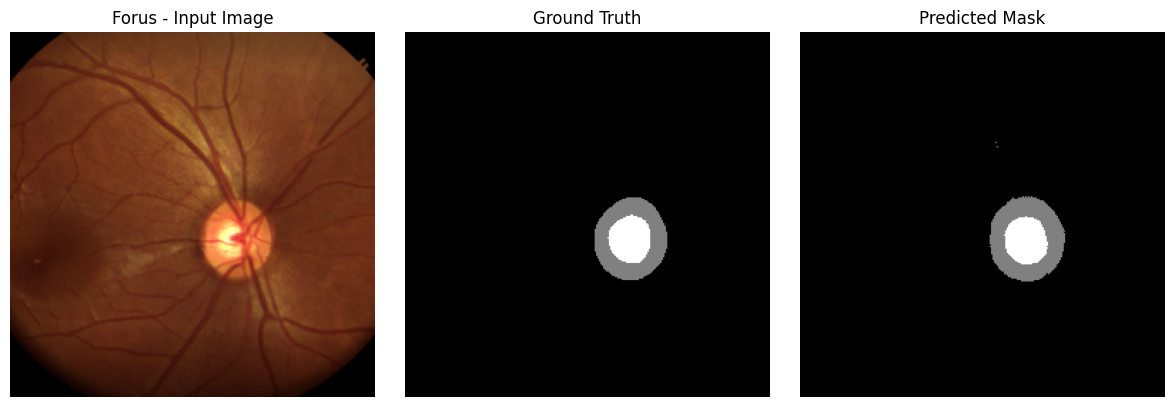

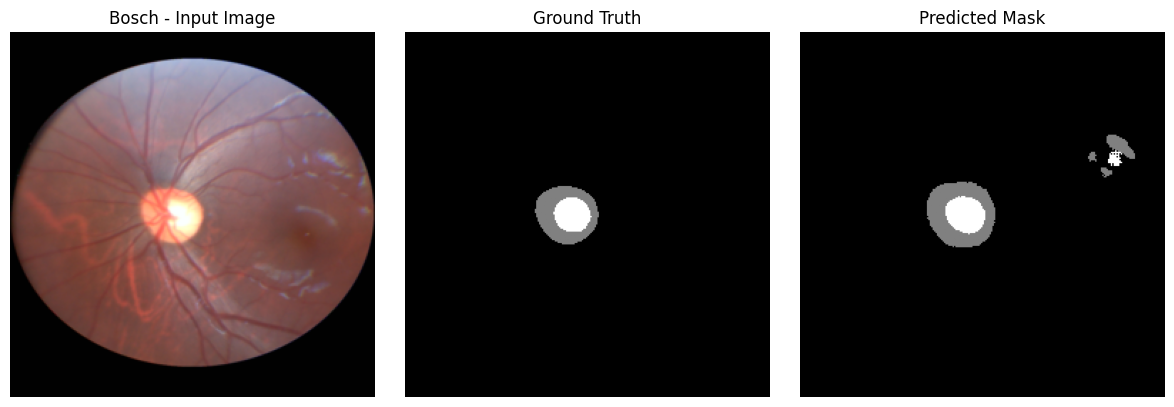

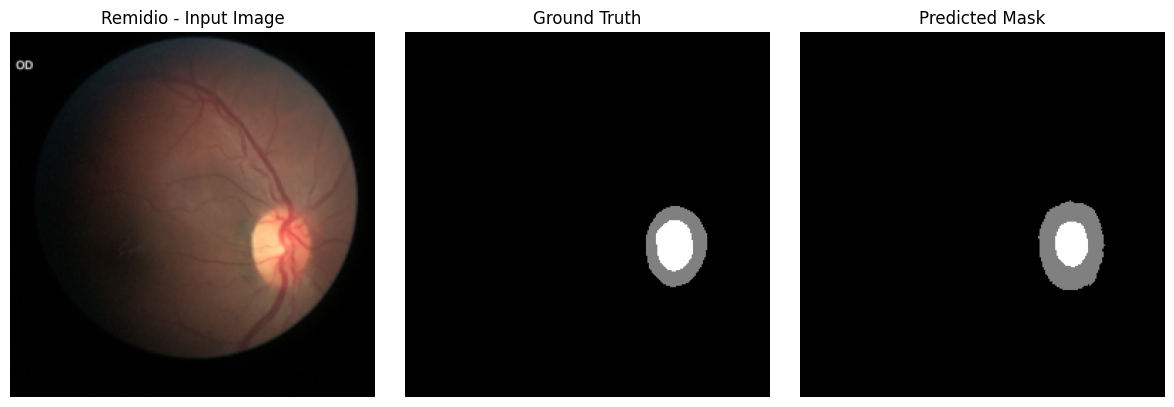

In [ ]:
baseline_model = ADABN(3,3)
baseline_model.load_state_dict(torch.load("/content/baseline_model.pth", map_location=device))
baseline_model.to(device)
plot_device_examples(baseline_model, tls)

### Task 2

In [ ]:
# task 2: Solution including strategies to account for imbalance data

In [ ]:
class AugmentWrapper(Dataset):
    """
    Wraps an existing dataset, applying random flips + random gamma to the image Tensor,
    while leaving the label Tensor aligned.

    - Horizontal flip (default p=0.5)
    - Vertical flip (default p=0.2)
    - Random gamma (default p=0.3) in range [0.6, 1.4]

    The data dictionary from the dataset is unchanged except for 'image' and 'label',
    which are returned after augmentation.
    """
    def __init__(self,
                 dataset,
                 p_hflip=0.5,
                 p_vflip=0.2,
                 p_gamma=0.3,
                 gamma_min=0.6,
                 gamma_max=1.4):
        """
        dataset:   The dataset (already does resize/crop/etc).
        p_hflip:   Probability of horizontal flip
        p_vflip:   Probability of vertical flip
        p_gamma:   Probability of applying random gamma
        gamma_min, gamma_max: Range for random gamma
        """
        self.dataset   = dataset
        self.p_hflip   = p_hflip
        self.p_vflip   = p_vflip
        self.p_gamma   = p_gamma
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the normal dict from the dataset
        data = self.dataset[idx]
        img  = data['image']      # shape [3,H,W]
        lbl  = data['label']      # shape [H,W]

        # Random horizontal flip
        if random.random() < self.p_hflip:
            img = torch.flip(img, dims=[2])  # Flip dimension W
            lbl = torch.flip(lbl, dims=[1])  # Flip dimension W

        # Random vertical flip
        if random.random() < self.p_vflip:
            img = torch.flip(img, dims=[1])  # Flip dimension H
            lbl = torch.flip(lbl, dims=[0])  # Flip dimension H

        # Random gamma
        if random.random() < self.p_gamma:
            # We do TF.adjust_gamma on the image only
            gamma_val = random.uniform(self.gamma_min, self.gamma_max)
            img = TF.adjust_gamma(img, gamma=gamma_val, gain=1.0)

        # Put them back
        data['image'] = img
        data['label'] = lbl
        return data

In [ ]:
print(f"Train set size = {len(train_dataset)}, Val set size = {len(val_dataset)}")

# Wrap the train subset in the AugmentWrapper so it applies random flips, etc.
train_dataset_aug = AugmentWrapper(train_dataset, p_hflip=0.5, p_vflip=0.2)
val_dataset_aug   = val_dataset  # no augmentation

# Build DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=4, shuffle=True, num_workers=12)
val_loader_aug = DataLoader(val_dataset_aug,   batch_size=4, shuffle=False, num_workers=12)


Train set size = 807, Val set size = 202


In [ ]:
augmentation_model = ADABN(num_classes=3, num_channels=3)
augmentation_model, train_loss_aug, val_loss_aug = train_func(augmentation_model, train_loader_aug, val_loader_aug, class_weights, num_epochs = 10)

Model is on device: cuda:0


100%|██████████| 202/202 [00:16<00:00, 12.07it/s]


Avg Dice Scores - Background: 0.9858, Disc: 0.6100, Cup: 0.8214
Epoch [1/10], Training Loss: 0.0024456317864198474, Validation Loss: 0.3097157323477315


100%|██████████| 202/202 [00:15<00:00, 12.83it/s]


Avg Dice Scores - Background: 0.9962, Disc: 0.7859, Cup: 0.8761
Epoch [2/10], Training Loss: 0.001116380950388704, Validation Loss: 0.20146146738061718


100%|██████████| 202/202 [00:16<00:00, 12.46it/s]


Avg Dice Scores - Background: 0.9968, Disc: 0.8062, Cup: 0.8896
Epoch [3/10], Training Loss: 0.0009022385061646125, Validation Loss: 0.17047281636326922


100%|██████████| 202/202 [00:15<00:00, 13.01it/s]


Avg Dice Scores - Background: 0.9938, Disc: 0.7245, Cup: 0.8551
Epoch [4/10], Training Loss: 0.0008132788440770068, Validation Loss: 0.1532733149680437


100%|██████████| 202/202 [00:15<00:00, 13.05it/s]


Avg Dice Scores - Background: 0.9968, Disc: 0.8114, Cup: 0.8756
Epoch [5/10], Training Loss: 0.0007247327923783483, Validation Loss: 0.13615628872431962


100%|██████████| 202/202 [00:15<00:00, 12.90it/s]


Avg Dice Scores - Background: 0.9969, Disc: 0.8199, Cup: 0.8913
Epoch [6/10], Training Loss: 0.0006786012910134816, Validation Loss: 0.12782246677898892


100%|██████████| 202/202 [00:15<00:00, 13.02it/s]


Avg Dice Scores - Background: 0.9969, Disc: 0.7971, Cup: 0.8712
Epoch [7/10], Training Loss: 0.0006411734765013718, Validation Loss: 0.1274766527554568


100%|██████████| 202/202 [00:15<00:00, 12.90it/s]


Avg Dice Scores - Background: 0.9945, Disc: 0.7438, Cup: 0.8403
Epoch [8/10], Training Loss: 0.0006551304756324206, Validation Loss: 0.13468548363330318


100%|██████████| 202/202 [00:15<00:00, 12.93it/s]


Avg Dice Scores - Background: 0.9953, Disc: 0.7897, Cup: 0.8093
Epoch [9/10], Training Loss: 0.0007130211742689605, Validation Loss: 0.1263405858886008


100%|██████████| 202/202 [00:15<00:00, 12.72it/s]


Avg Dice Scores - Background: 0.9929, Disc: 0.7493, Cup: 0.7978
Epoch [10/10], Training Loss: 0.000605743442126237, Validation Loss: 0.13567526346328213
Best model restored.


In [ ]:
torch.save(augmentation_model.state_dict(), 'augmentation_model.pth')
np.save('val_loss_aug.npy', np.array(val_loss_aug))
augmentation_test_df = evaluate_segmentation_model_df(augmentation_model, test_loader_all, device)
augmentation_test_df.to_csv('augmentation_test_df.csv', index=False)

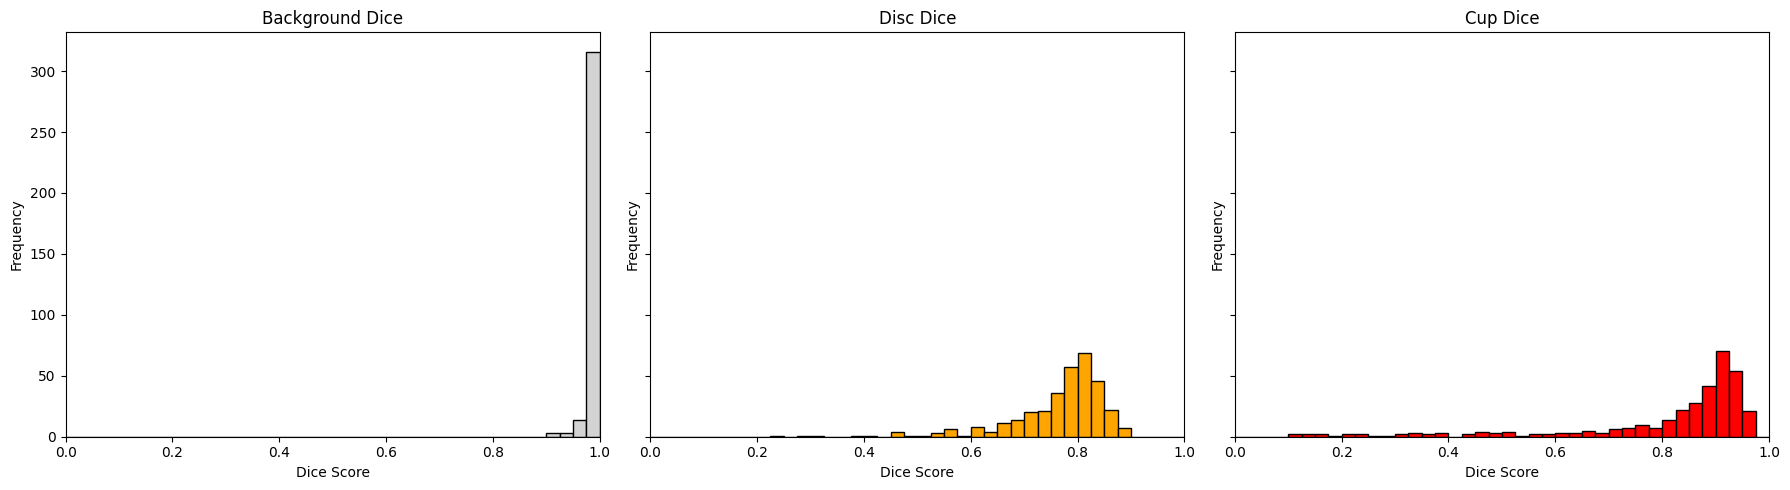

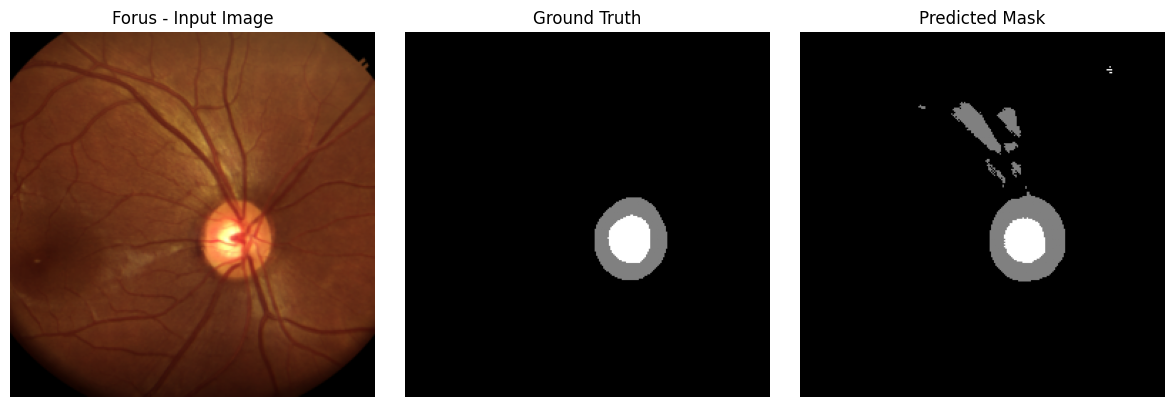

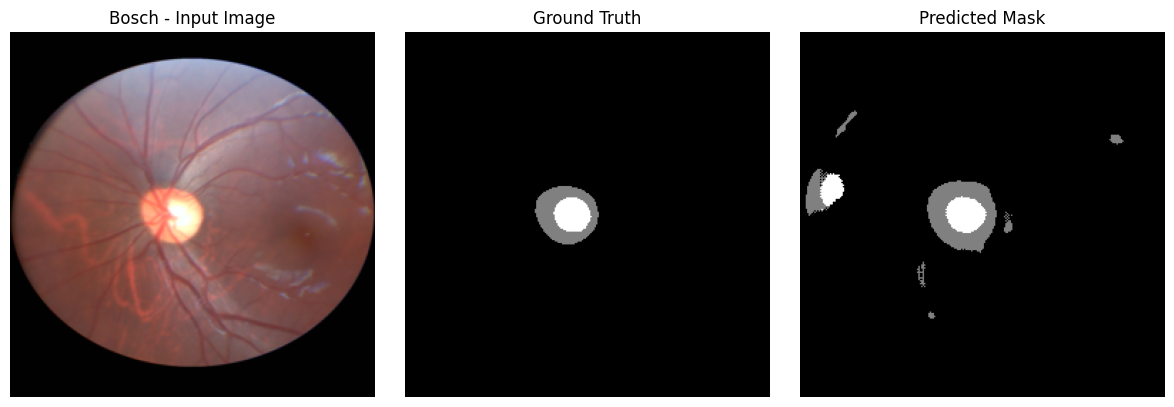

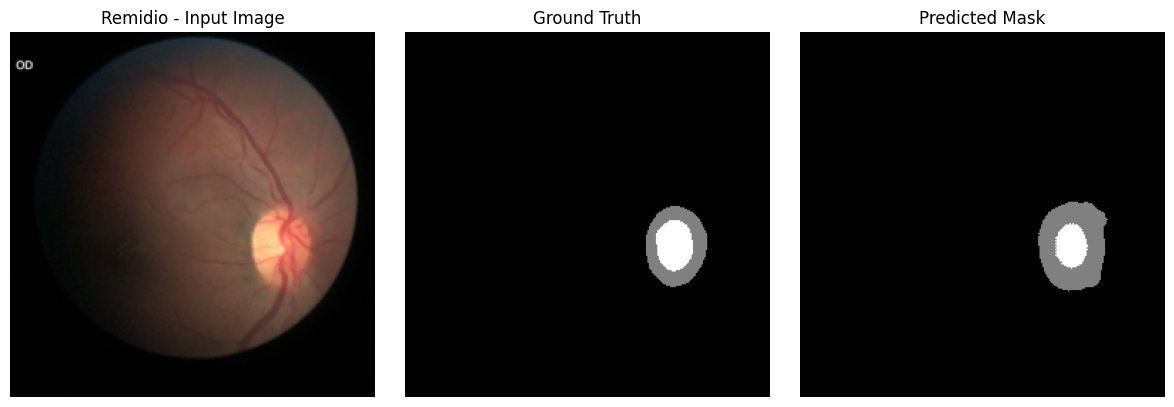

In [ ]:
plot_dice_hist(augmentation_test_df)
plot_device_examples(augmentation_model, tls)

Undersampling - only use as much samples per device as the smallest sample set (device)


In [ ]:
from torch.utils.data import Dataset, ConcatDataset, Subset

# The number of available samples:
n_remidio = len(remidio_dataset)
n_bosch   = len(bosch_dataset)
n_forus   = len(forus_dataset)

# Minimum count across devices:
min_count = min(n_remidio, n_bosch, n_forus)

# Randomly pick `min_count` indices from each device
remidio_indices = random.sample(range(n_remidio), min_count)
bosch_indices   = random.sample(range(n_bosch),   min_count)
forus_indices   = random.sample(range(n_forus),   min_count)

# Wrap each device’s subset in a torch Subset
remidio_balanced = Subset(remidio_dataset, remidio_indices)
bosch_balanced   = Subset(bosch_dataset,   bosch_indices)
forus_balanced   = Subset(forus_dataset,   forus_indices)

# Concatenate to form a single balanced dataset
balanced_dataset = ConcatDataset([remidio_balanced, bosch_balanced, forus_balanced])

print("Balanced dataset size:", len(balanced_dataset))
print("Training dataset size:", train_size)
print("Validation dataset size:", val_size)

#  train and validation sets split (80% train, 20% validation)
train_size = int(0.8 * len(balanced_dataset))  # 80% for training
val_size = len(balanced_dataset) - train_size  # 20% for validation
train_dataset_balanced, val_dataset_balanced = random_split(balanced_dataset, [train_size, val_size])

#  training and validation sets dataloader
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=4, shuffle=True, num_workers = 12)
val_loader_balanced = DataLoader(val_dataset_balanced, batch_size=4, shuffle=False, num_workers=12)



Balanced dataset size: 285
Training dataset size: 807
Validation dataset size: 202


In [ ]:
balanced_model = ADABN(num_classes=3, num_channels=3)
balanced_model, train_loss_balanced, val_loss_balanced = train_func(balanced_model, train_loader_balanced, val_loader_balanced, class_weights, num_epochs = 10)
np.save('val_loss_balanced.npy', np.array(val_loss_balanced))
torch.save(balanced_model.state_dict(), 'balanced_model.pth')

Model is on device: cuda:0


100%|██████████| 57/57 [00:03<00:00, 14.42it/s]


Avg Dice Scores - Background: 0.8127, Disc: 0.1362, Cup: 0.2165
Epoch [1/10], Training Loss: 0.013908700461973223, Validation Loss: 0.6619140108426412


100%|██████████| 57/57 [00:03<00:00, 14.38it/s]


Avg Dice Scores - Background: 0.9091, Disc: 0.2545, Cup: 0.3794
Epoch [2/10], Training Loss: 0.008536945823230314, Validation Loss: 0.5995227674643199


100%|██████████| 57/57 [00:03<00:00, 14.62it/s]


Avg Dice Scores - Background: 0.9615, Disc: 0.4095, Cup: 0.4800
Epoch [3/10], Training Loss: 0.006705013104643077, Validation Loss: 0.3768079042434692


100%|██████████| 57/57 [00:04<00:00, 14.00it/s]


Avg Dice Scores - Background: 0.9851, Disc: 0.5591, Cup: 0.8282
Epoch [4/10], Training Loss: 0.005189834195270873, Validation Loss: 0.30640459855397545


100%|██████████| 57/57 [00:04<00:00, 13.66it/s]


Avg Dice Scores - Background: 0.9927, Disc: 0.6737, Cup: 0.8017
Epoch [5/10], Training Loss: 0.004203877487744725, Validation Loss: 0.25570549567540485


100%|██████████| 57/57 [00:03<00:00, 14.53it/s]


Avg Dice Scores - Background: 0.9868, Disc: 0.5923, Cup: 0.8302
Epoch [6/10], Training Loss: 0.003671604946196061, Validation Loss: 0.25551074345906577


100%|██████████| 57/57 [00:04<00:00, 13.75it/s]


Avg Dice Scores - Background: 0.9920, Disc: 0.6477, Cup: 0.8286
Epoch [7/10], Training Loss: 0.0035453922484756876, Validation Loss: 0.2240687330563863


100%|██████████| 57/57 [00:04<00:00, 13.24it/s]


Avg Dice Scores - Background: 0.9953, Disc: 0.7252, Cup: 0.8449
Epoch [8/10], Training Loss: 0.0030532313259097753, Validation Loss: 0.21092937091986338


100%|██████████| 57/57 [00:04<00:00, 13.08it/s]


Avg Dice Scores - Background: 0.9948, Disc: 0.7290, Cup: 0.8713
Epoch [9/10], Training Loss: 0.002921013987662426, Validation Loss: 0.19472775012254714


100%|██████████| 57/57 [00:04<00:00, 13.02it/s]


Avg Dice Scores - Background: 0.9943, Disc: 0.7174, Cup: 0.8617
Epoch [10/10], Training Loss: 0.002833048241180286, Validation Loss: 0.21611848026514052
Best model restored.


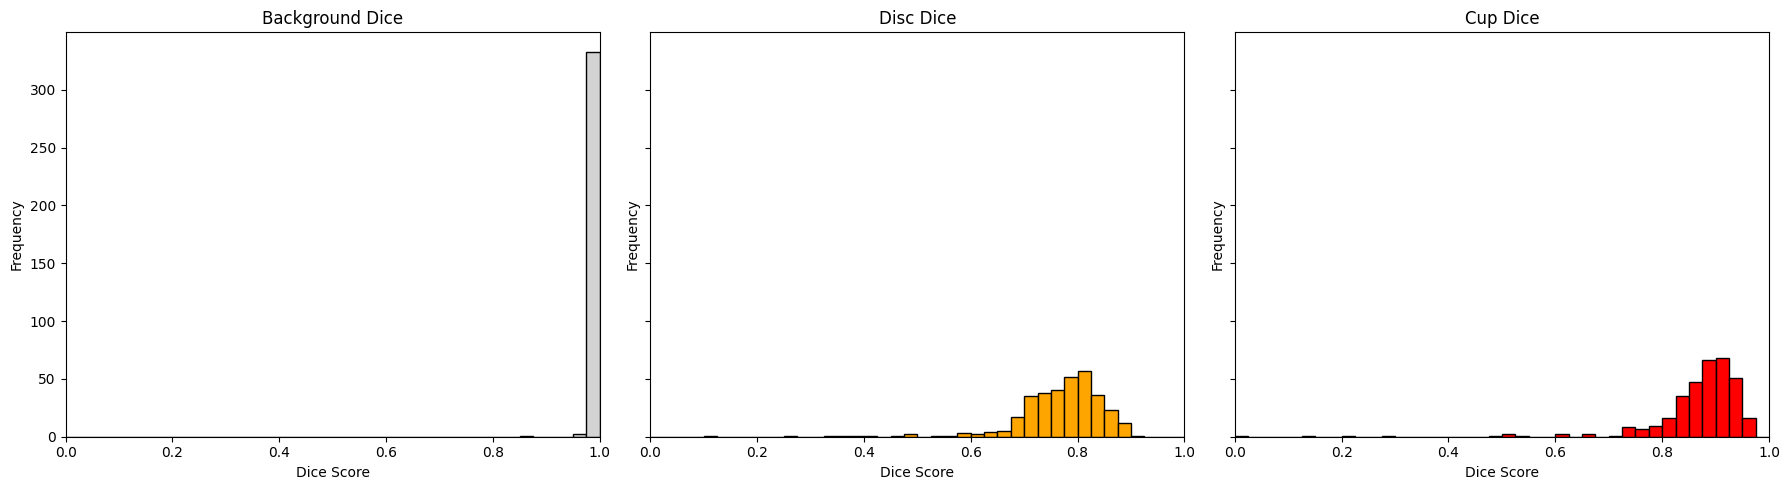

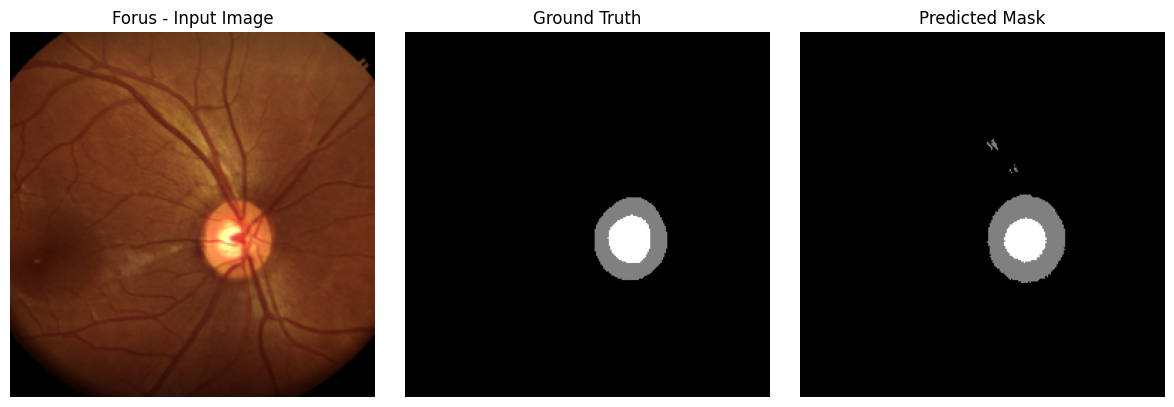

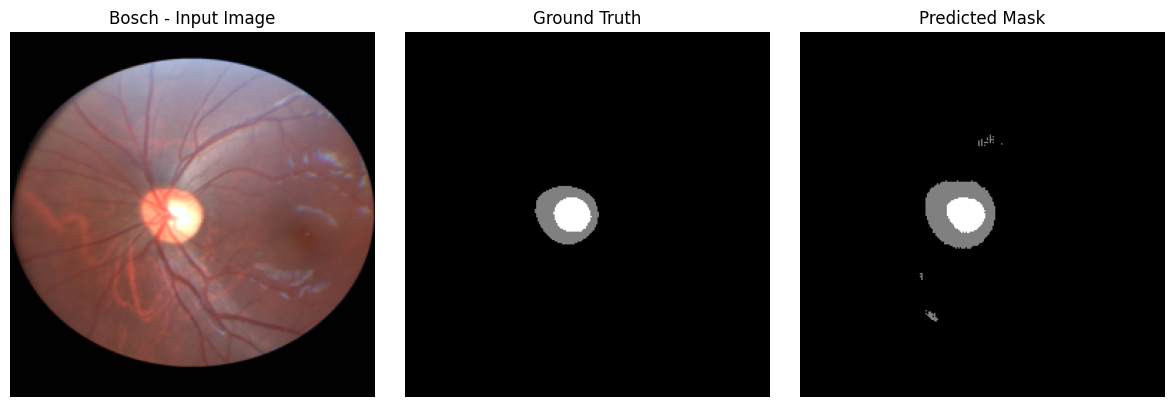

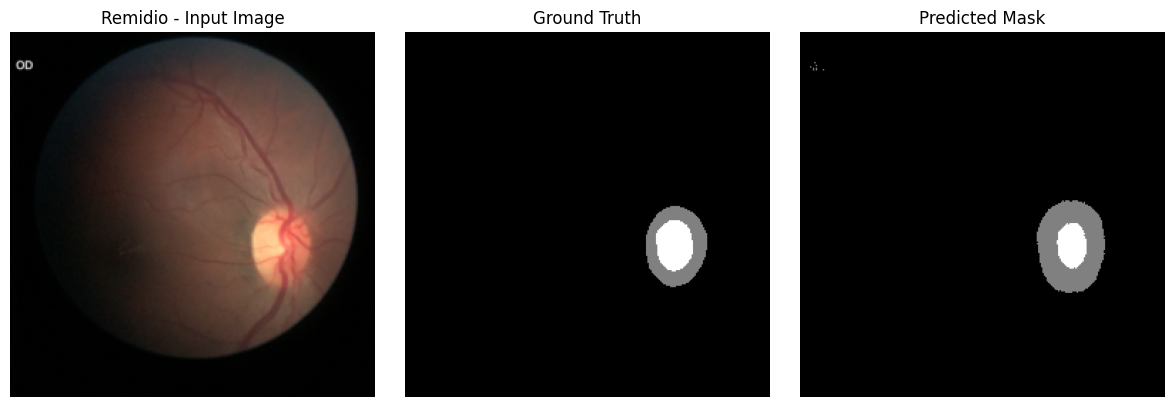

In [ ]:
balanced_test_df = evaluate_segmentation_model_df(balanced_model, test_loader_all, device)
balanced_test_df.to_csv('balanced_test_df.csv', index=False)
plot_dice_hist(balanced_test_df)
plot_device_examples(balanced_model, tls)

Over-sampling - get the same amount of samples from each set in each batch - the smaller sets will be over sampled

In [ ]:
# Count how many samples each device has
device_counts = {
    "Remidio": len(remidio_dataset),
    "Bosch":   len(bosch_dataset),
    "Forus":   len(forus_dataset),
}

print(device_counts)

{'Remidio': 810, 'Bosch': 104, 'Forus': 95}


In [ ]:
def dataset_index_for_concat(concat_dataset, idx):
    """Given an index `idx` into ConcatDataset, return (sub_ds_idx, sub_ds_local_idx)."""
    if idx < 0:
        if -idx > len(concat_dataset):
            raise ValueError("Absolute index out of range")
        idx = len(concat_dataset) + idx
    for i, csize in enumerate(concat_dataset.cumulative_sizes):
        if idx < csize:
            sub_idx = idx if i == 0 else idx - concat_dataset.cumulative_sizes[i - 1]
            return (i, sub_idx)
    raise IndexError("Index out of range in ConcatDataset")


def make_sample_weights_for_devices(subset, device_counts):
    """
    subset: a Subset referencing a ConcatDataset of multiple device datasets
    device_counts: dict with device_name -> count of total samples in that device
    Returns: list of sample weights (floats)
    """
    sample_weights = []
    # The parent ConcatDataset
    concat_ds = subset.dataset  # The underlying dataset for the Subset

    for local_idx in subset.indices:  # these are indices into the ConcatDataset
        sub_ds_idx, sub_ds_local = dataset_index_for_concat(concat_ds, local_idx)
        # get the actual sub-dataset
        sub_dataset = concat_ds.datasets[sub_ds_idx]
        dev_name = sub_dataset.device_name  # each CustomDataset has a device_name

        # The weight is inversely proportional to the device's total sample count
        w = 1.0 / float(device_counts[dev_name])
        sample_weights.append(w)

    return sample_weights


In [ ]:
train_sample_weights = make_sample_weights_for_devices(train_dataset, device_counts)

# Convert to the form required by WeightedRandomSampler
train_sample_weights_tensor = torch.DoubleTensor(train_sample_weights)


In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader

train_sampler = WeightedRandomSampler(
    weights=train_sample_weights_tensor,
    num_samples=len(train_sample_weights_tensor),  # same size as train set
    replacement=True  # needed to oversample properly
)

train_loader_oversampled = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    sampler=train_sampler,
    num_workers=12
)

# The validation loader is just a normal DataLoader: no weighting.
val_loader_oversampled = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=12
)


In [ ]:
oversampled_model  = ADABN(num_classes=3, num_channels=3)
oversampled_model, train_loss_oversampled, val_loss_oversampled = train_func(oversampled_model, train_loader_oversampled, val_loader_oversampled, class_weights, num_epochs = 10)
torch.save(oversampled_model.state_dict(), 'oversampled_model.pth')

Model is on device: cuda:0


100%|██████████| 202/202 [00:12<00:00, 16.17it/s]


Avg Dice Scores - Background: 0.9922, Disc: 0.6708, Cup: 0.8251
Epoch [1/10], Training Loss: 0.002431936517508284, Validation Loss: 0.3151315658115873


100%|██████████| 202/202 [00:12<00:00, 16.39it/s]


Avg Dice Scores - Background: 0.9940, Disc: 0.6859, Cup: 0.8561
Epoch [2/10], Training Loss: 0.0010700698745839678, Validation Loss: 0.19478920481952966


100%|██████████| 202/202 [00:12<00:00, 16.45it/s]


Avg Dice Scores - Background: 0.9968, Disc: 0.7979, Cup: 0.8777
Epoch [3/10], Training Loss: 0.0007873114359859695, Validation Loss: 0.2026207420755835


100%|██████████| 202/202 [00:12<00:00, 16.69it/s]


Avg Dice Scores - Background: 0.9965, Disc: 0.8000, Cup: 0.8747
Epoch [4/10], Training Loss: 0.0006913329274595842, Validation Loss: 0.17467551999816708


100%|██████████| 202/202 [00:12<00:00, 16.43it/s]


Avg Dice Scores - Background: 0.9970, Disc: 0.8076, Cup: 0.8938
Epoch [5/10], Training Loss: 0.0006110452277314346, Validation Loss: 0.15602249038570068


100%|██████████| 202/202 [00:12<00:00, 16.51it/s]


Avg Dice Scores - Background: 0.9966, Disc: 0.7917, Cup: 0.8843
Epoch [6/10], Training Loss: 0.0005405950199773575, Validation Loss: 0.14331985060490815


100%|██████████| 202/202 [00:13<00:00, 14.84it/s]


Avg Dice Scores - Background: 0.9951, Disc: 0.7574, Cup: 0.8482
Epoch [7/10], Training Loss: 0.00058249652815904, Validation Loss: 0.16622429647866419


100%|██████████| 202/202 [00:12<00:00, 16.52it/s]


Avg Dice Scores - Background: 0.9981, Disc: 0.8492, Cup: 0.8933
Epoch [8/10], Training Loss: 0.0005355251615388804, Validation Loss: 0.13476293168815912


100%|██████████| 202/202 [00:13<00:00, 15.45it/s]


Avg Dice Scores - Background: 0.9973, Disc: 0.8233, Cup: 0.8981
Epoch [9/10], Training Loss: 0.0005151791857410711, Validation Loss: 0.1265770657097592


100%|██████████| 202/202 [00:12<00:00, 16.20it/s]


Avg Dice Scores - Background: 0.9980, Disc: 0.8495, Cup: 0.8963
Epoch [10/10], Training Loss: 0.0005009057807894316, Validation Loss: 0.13260204593340555
Best model restored.


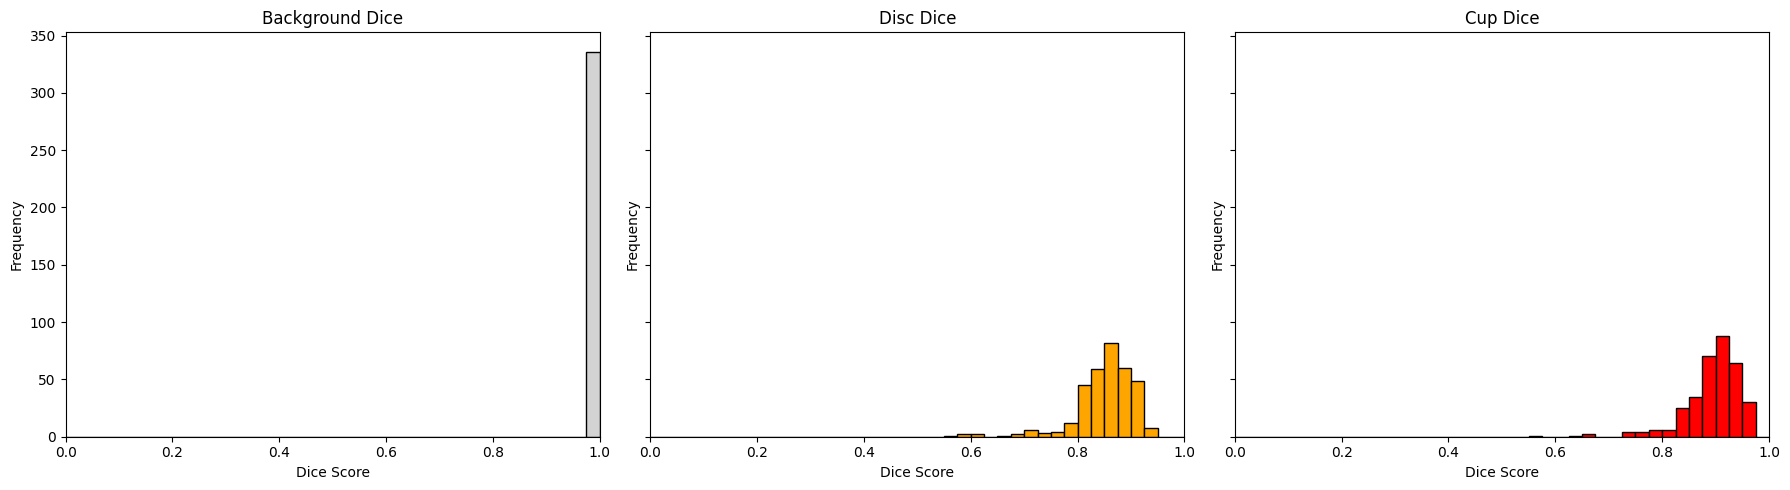

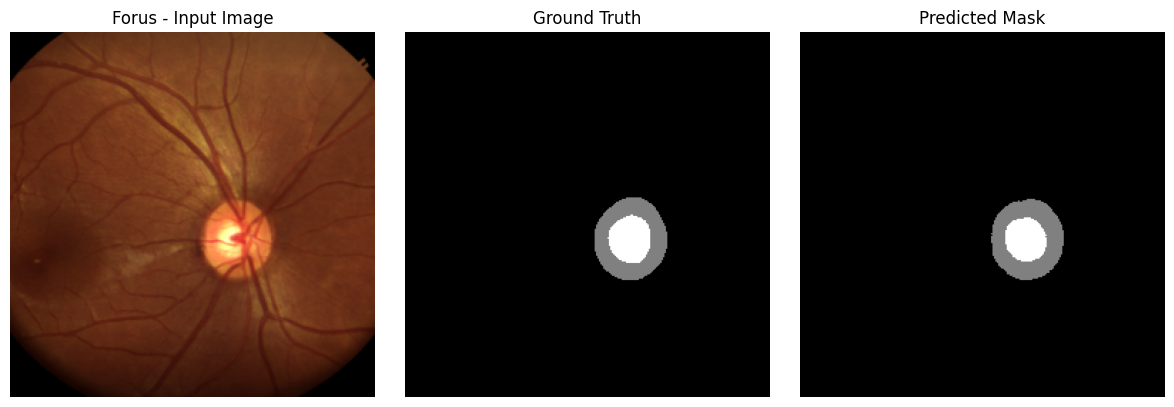

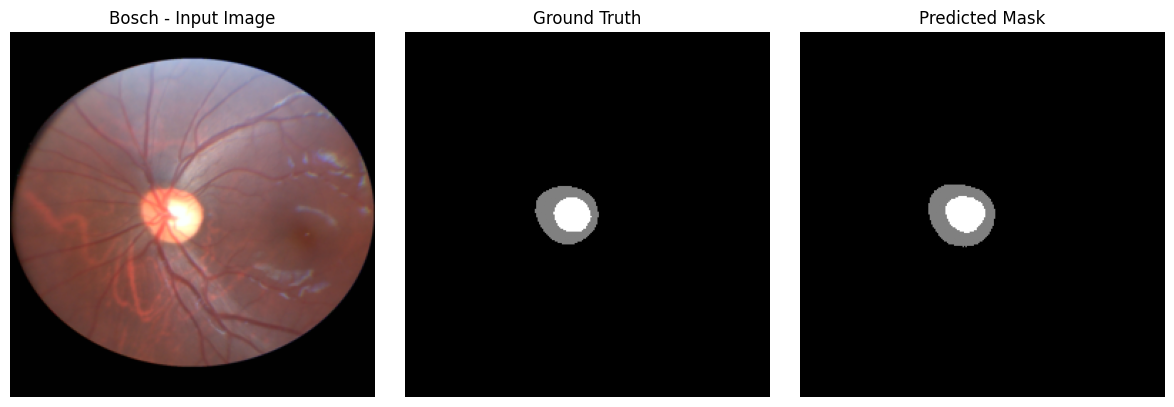

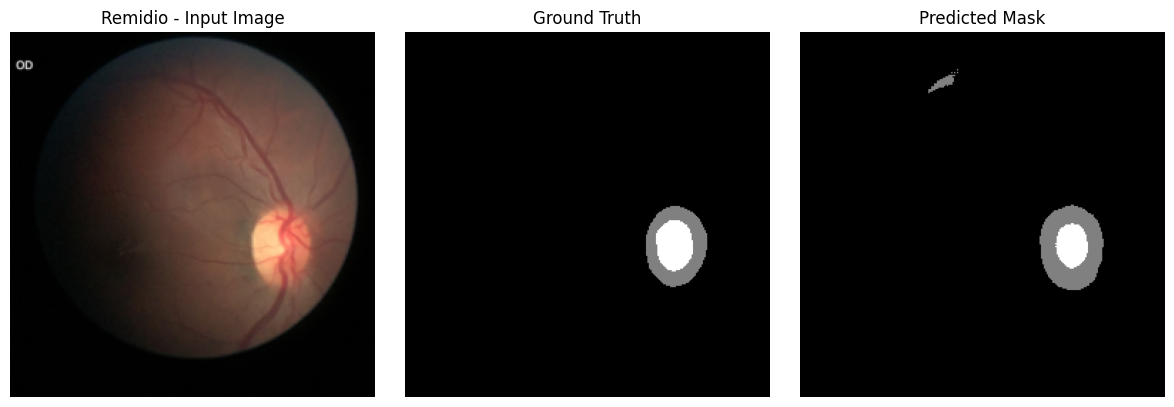

In [ ]:
np.save('val_loss_oversampled.npy', np.array(val_loss_oversampled))
oversampled_test_df = evaluate_segmentation_model_df(oversampled_model, test_loader_all, device)
oversampled_test_df.to_csv('oversampled_test_df.csv', index=False)
plot_dice_hist(oversampled_test_df)
plot_device_examples(oversampled_model, tls)

### Task 3


In [ ]:
#Define the multitask architecture. Wr can use encoder and decoder classes from before

class MultiTaskUNet(nn.Module):
    def __init__(self, num_classes=3, in_channels=3):
        super(MultiTaskUNet, self).__init__()

        # Encoder
        self.enc1 = _EncoderBN(in_channels, 64, 5, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = _EncoderBN(64, 96, 3, 1)
        self.enc3 = _EncoderBN(96, 128, 3, 1)
        self.enc4 = _EncoderBN(128, 256, 3, 1)
        self.center = _DecoderBN(256, 512, 256)

        # Decoder (note: dec4 input size changed to accommodate aux injection)
        self.dec4 = _DecoderBN(512 + 64, 256, 128)
        self.dec3 = _DecoderBN(256, 128, 96)
        self.dec2 = _DecoderBN(96 * 2, 96, 64)
        self.dec1 = prefinalBN(128, 64)
        self.segmentation_head = nn.Conv2d(64, num_classes, kernel_size=1)

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        # Regression head (ACDR, VCDR, HCDR)
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # 3 outputs: ACDR, VCDR, HCDR
        )

        # Classification head takes only regression output
        self.classifier = nn.Sequential(
            nn.Linear(256 + 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # Project auxiliary predictions into spatial decoder input
        self.aux_proj = nn.Sequential(
            nn.Linear(4, 64),  # 3 reg targets + 1 predicted glaucoma label
            nn.ReLU(),
        )

        initialize_weights(self)

    def forward(self, x):
        # Shared encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = F.dropout(self.enc4(self.pool(enc3)))
        center = self.center(self.pool(enc4))

        # Global pooled features
        pooled = self.global_pool(center)
        features = self.flatten(pooled)

        # Regression first
        regression_output = self.regressor(features)         # [B, 3]

        # Classification
        cls_input = torch.cat([features, regression_output.detach()], dim=1)  # [B, 256 + 3]
        classification_output = self.classifier(cls_input)  # [B, 1]

        # Project regression + classification to spatial map
        glaucoma_prob = torch.sigmoid(classification_output)  # [B, 1]
        aux_input = torch.cat([regression_output, glaucoma_prob], dim=1)  # [B, 4]
        aux_feats = self.aux_proj(aux_input)                 # [B, 64]
        aux_feats = aux_feats.unsqueeze(-1).unsqueeze(-1)    # [B, 64, 1, 1]
        aux_feats = aux_feats.expand(-1, -1, center.shape[2], center.shape[3])  # [B, 64, H, W]

        # Inject into decoder
        center_augmented = torch.cat([center, aux_feats], dim=1)  # [B, 320, H, W]

        # Decoder
        dec4 = self.dec4(torch.cat([center_augmented, enc4], dim=1))
        dec3 = self.dec3(torch.cat([dec4, enc3], dim=1))
        dec2 = self.dec2(torch.cat([dec3, enc2], dim=1))
        dec1 = self.dec1(torch.cat([dec2, enc1], dim=1))
        segmentation_output = self.segmentation_head(dec1)

        return {
            'segmentation': segmentation_output,         # [B, C, H, W]
            'glaucoma_class': classification_output,     # [B, 1]
            'area_preds': regression_output              # [B, 3] for ACDR, VCDR, HCDR
        }

In [ ]:
#Training function for a multitask model
def train_multitask_model(model, t_loader, v_loader, class_weights, glauc_weight,
                          num_epochs=10, lambda_seg=1.0, lambda_cls=1.0, lambda_reg=1.0):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Model is on device: {next(model.parameters()).device}")

    # Define loss functions)
    seg_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    cls_loss_fn = nn.BCEWithLogitsLoss(pos_weight = glauc_weight)
    reg_loss_fn = nn.MSELoss()

    val_loss_list_seg = []
    train_loss_list = []
    val_loss_list_class = []
    val_loss_list_reg = []
    val_total_loss_list = []
    optimizer = optim.Adam(model.parameters(), lr=1e-4) #Reinitializes optimizer
    initialize_weights(model)       # Reinitialises weights

    best_val_dice = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(t_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            glaucoma_labels = batch['info']['majority_decision'].float().unsqueeze(1).to(device)  # shape [B, 1]

            # Stack Cup Area and Disc Area for regression
            area_targets = torch.stack([
                batch['info']['ACDR'].float().to(device),
                batch['info']['VCDR'].float().to(device),
                batch['info']['HCDR'].float().to(device)
            ], dim=1)  # shape [B, 3]

            optimizer.zero_grad()
            outputs = model(images)

            seg_logits = outputs['segmentation']
            glaucoma_logits = outputs['glaucoma_class']
            area_preds = outputs['area_preds']

            seg_loss = seg_loss_fn(seg_logits, labels)
            cls_loss = cls_loss_fn(glaucoma_logits, glaucoma_labels)
            reg_loss = reg_loss_fn(area_preds, area_targets)

            total_loss = lambda_seg * seg_loss + lambda_cls * cls_loss + lambda_reg * reg_loss

            total_loss.backward()

            optimizer.step()

            running_loss += total_loss.item()

        running_loss /= len(t_loader)
        train_loss_list.append(running_loss)

        # Validation
        model.eval()
        val_seg_loss = 0.0
        val_cls_loss = 0.0
        val_reg_loss = 0.0
        val_total_loss = 0.0
        total_dice = torch.zeros(3)

        with torch.no_grad():
            for batch in v_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                glaucoma_labels = batch['info']['majority_decision'].float().unsqueeze(1).to(device)
                # Stack Cup Area and Disc Area for regression
                area_targets = torch.stack([
                    batch['info']['ACDR'].float().to(device),
                    batch['info']['VCDR'].float().to(device),
                    batch['info']['HCDR'].float().to(device)
                ], dim=1)  # shape [B, 3]

                outputs = model(images)

                seg_logits = outputs['segmentation']
                glaucoma_logits = outputs['glaucoma_class']
                area_preds = outputs['area_preds']

                seg_loss = seg_loss_fn(seg_logits, labels)
                cls_loss = cls_loss_fn(glaucoma_logits, glaucoma_labels)
                reg_loss = reg_loss_fn(area_preds, area_targets)

                total_loss = lambda_seg * seg_loss + lambda_cls * cls_loss + lambda_reg * reg_loss

                val_seg_loss += seg_loss.item()
                val_cls_loss += cls_loss.item()
                val_reg_loss += reg_loss.item()
                val_total_loss += total_loss.item()

                # Compute Dice
                preds = torch.argmax(seg_logits, dim=1)  # [B, H, W]
                dice_scores = dice_score_per_class(preds, labels)
                total_dice += torch.tensor(dice_scores)


        val_total_loss_list.append(val_total_loss / len(v_loader))
        val_loss_list_seg.append(val_seg_loss / len(v_loader))
        val_loss_list_class.append(val_cls_loss / len(v_loader))
        val_loss_list_reg.append(val_reg_loss / len(v_loader))
        avg_dice = total_dice / len(v_loader)
        val_dice = torch.sum(avg_dice)/3
        print(f"Avg Dice Scores - Background: {avg_dice[0]:.4f}, Disc: {avg_dice[1]:.4f}, Cup: {avg_dice[2]:.4f}") # to check the model segments the cup
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(t_loader)}, Validation Total Loss: {val_total_loss / len(v_loader)}")
        print(f"Validation Seg Loss: {val_seg_loss / len(v_loader)}, Validation Cls Loss: {val_cls_loss / len(v_loader)}, Validation Reg Loss: {val_reg_loss / len(v_loader)}")

        if val_dice < best_val_dice:
          best_val_dice = val_dice
          best_model_state = model.state_dict()

        '''if early_stopping(val_loss):
            print(f"Early stopping triggered at Epoch {epoch+1}")
            break'''

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model restored.")

    return model, train_loss_list, val_total_loss_list, val_loss_list_seg, val_loss_list_class, val_loss_list_reg

In [ ]:
#Address Imbalance in Glaucoma vs non-Glaucoma
num_pos = 0
num_neg = 0

for sample in train_dataset:
    label = sample['info']['majority_decision']
    if label == 1:
        num_pos += 1
    elif label == 0:
        num_neg += 1

print(f"Positive (glaucoma suspect): {num_pos}")
print(f"Negative (normal): {num_neg}")

Positive (glaucoma suspect): 102
Negative (normal): 705


In [ ]:
# Compute pos_weight for BCEWithLogitsLoss
pos_weight = torch.tensor([num_neg / num_pos], device=device)
print(f"pos_weight: {pos_weight.item():.4f}")

pos_weight: 6.9118


In [ ]:
#Compute average ragios for all, glaucoma, and non-glaucoma
import pandas as pd

# Accumulators
glauc_acdr, glauc_vcdr, glauc_hcdr = [], [], []
normal_acdr, normal_vcdr, normal_hcdr = [], [], []

for sample in train_dataset:
    label = sample['info']['majority_decision']
    acdr = sample['info']['ACDR']
    vcdr = sample['info']['VCDR']
    hcdr = sample['info']['HCDR']

    if label == 1:  # Glaucoma
        glauc_acdr.append(acdr)
        glauc_vcdr.append(vcdr)
        glauc_hcdr.append(hcdr)
    else:  # Normal
        normal_acdr.append(acdr)
        normal_vcdr.append(vcdr)
        normal_hcdr.append(hcdr)

# Convert to DataFrames
df_glauc = pd.DataFrame({'ACDR': glauc_acdr, 'VCDR': glauc_vcdr, 'HCDR': glauc_hcdr})
df_normal = pd.DataFrame({'ACDR': normal_acdr, 'VCDR': normal_vcdr, 'HCDR': normal_hcdr})
df_total = pd.concat([df_glauc, df_normal])


 Total subjects: 807
ACDR    0.217287
VCDR    0.460616
HCDR    0.450271
Name: All subjects, dtype: float64

 Glaucoma subjects: 102
ACDR    0.340520
VCDR    0.589618
HCDR    0.570186
Name: Glaucoma, dtype: float64

 Normal subjects: 705
ACDR    0.199458
VCDR    0.441952
HCDR    0.432922
Name: Normal, dtype: float64


In [ ]:
def print_group_stats(df, group_name):
    print(f"\n {group_name} (n={len(df)})")
    means = df.mean()
    stds = df.std()
    formatted = [f"{means[col]:.3f} ± {stds[col]:.3f}" for col in df.columns]
    print(pd.Series(formatted, index=df.columns, name=group_name))

print_group_stats(df_total, "All Subjects")
print_group_stats(df_glauc, "Glaucoma")
print_group_stats(df_normal, "Normal")


 All Subjects (n=807)
ACDR    0.217 ± 0.095
VCDR    0.461 ± 0.097
HCDR    0.450 ± 0.106
Name: All Subjects, dtype: object

 Glaucoma (n=102)
ACDR    0.341 ± 0.084
VCDR    0.590 ± 0.066
HCDR    0.570 ± 0.083
Name: Glaucoma, dtype: object

 Normal (n=705)
ACDR    0.199 ± 0.082
VCDR    0.442 ± 0.086
HCDR    0.433 ± 0.097
Name: Normal, dtype: object


In [ ]:
#Welch's t-test on diffeence in glaucoma/not for each ratio
from scipy.stats import ttest_ind

print("\nT-test results:")
for metric in ['ACDR', 'VCDR', 'HCDR']:
    t_stat, p_val = ttest_ind(df_glauc[metric], df_normal[metric], equal_var=False)
    print(f"{metric}: t={t_stat:.2f}, p={p_val:.4e}")


T-test results:
ACDR: t=15.83, p=3.8549e-32
VCDR: t=20.24, p=1.7241e-45
HCDR: t=15.26, p=6.7160e-32


In [ ]:
#Train multitask model
multitask_model= MultiTaskUNet()

multitask_model, train_loss_list_MT, val_total_loss_list_MT, \
  val_loss_list_seg_MT, val_loss_list_class_MT, \
  val_loss_list_reg_MT = train_multitask_model(
    model=multitask_model,
    t_loader=train_loader,
    v_loader=val_loader,
    class_weights = class_weights,
    glauc_weight = pos_weight,
    num_epochs=10,
    lambda_seg=5,
    lambda_cls=1.0,
    lambda_reg=5
)
np.save('val_loss_multitask_total.npy', np.array(val_total_loss_list_MT))
np.save('val_loss_multitask_seg.npy', np.array(val_loss_list_seg_MT))
np.save('val_loss_multitask_class.npy', np.array(val_loss_list_class_MT))
np.save('val_loss_multitask_reg.npy', np.array(val_loss_list_reg_MT))
torch.save(multitask_model.state_dict(), 'multitask_model.pth')

Model is on device: cuda:0


100%|██████████| 202/202 [00:15<00:00, 12.63it/s]


Avg Dice Scores - Background: 0.9842, Disc: 0.6081, Cup: 0.7160
Epoch [1/10], Training Loss: 0.017031876862767793, Validation Total Loss: 2.86556166527318
Validation Seg Loss: 0.3013865602951424, Validation Cls Loss: 1.3071004257482641, Validation Reg Loss: 0.010305691342663896


100%|██████████| 202/202 [00:15<00:00, 12.85it/s]


Avg Dice Scores - Background: 0.9942, Disc: 0.7516, Cup: 0.8600
Epoch [2/10], Training Loss: 0.011411882249669297, Validation Total Loss: 2.3646362529081455
Validation Seg Loss: 0.19546395467192518, Validation Cls Loss: 1.322773331520604, Validation Reg Loss: 0.012908633410309752


100%|██████████| 202/202 [00:15<00:00, 13.12it/s]


Avg Dice Scores - Background: 0.9955, Disc: 0.7515, Cup: 0.7755
Epoch [3/10], Training Loss: 0.010118461294438767, Validation Total Loss: 2.2611129938387404
Validation Seg Loss: 0.1847147916754087, Validation Cls Loss: 1.291453376120212, Validation Reg Loss: 0.009217128100549327


100%|██████████| 202/202 [00:15<00:00, 12.99it/s]


Avg Dice Scores - Background: 0.9948, Disc: 0.7484, Cup: 0.8707
Epoch [4/10], Training Loss: 0.009668470276253982, Validation Total Loss: 1.9499763343848435
Validation Seg Loss: 0.1486370712518692, Validation Cls Loss: 1.1440718916116976, Validation Reg Loss: 0.012543821711933203


100%|██████████| 202/202 [00:15<00:00, 12.98it/s]


Avg Dice Scores - Background: 0.9948, Disc: 0.7724, Cup: 0.8727
Epoch [5/10], Training Loss: 0.009252468264812278, Validation Total Loss: 1.9401467828189625
Validation Seg Loss: 0.17577162092807247, Validation Cls Loss: 0.9966077839626986, Validation Reg Loss: 0.01293618066747691


100%|██████████| 202/202 [00:15<00:00, 13.12it/s]


Avg Dice Scores - Background: 0.9964, Disc: 0.8037, Cup: 0.8295
Epoch [6/10], Training Loss: 0.008688412400019331, Validation Total Loss: 2.458398192536597
Validation Seg Loss: 0.24845863440457513, Validation Cls Loss: 1.1581869587010027, Validation Reg Loss: 0.011583613927987423


100%|██████████| 202/202 [00:15<00:00, 13.01it/s]


Avg Dice Scores - Background: 0.9971, Disc: 0.8169, Cup: 0.8901
Epoch [7/10], Training Loss: 0.00862375285365794, Validation Total Loss: 1.9937692062527526
Validation Seg Loss: 0.12393632341249317, Validation Cls Loss: 1.3054427080879025, Validation Reg Loss: 0.01372897622686829


100%|██████████| 202/202 [00:15<00:00, 13.11it/s]


Avg Dice Scores - Background: 0.9962, Disc: 0.8180, Cup: 0.8297
Epoch [8/10], Training Loss: 0.008386463828150425, Validation Total Loss: 1.694947484661551
Validation Seg Loss: 0.12989082727946488, Validation Cls Loss: 0.9825138011399437, Validation Reg Loss: 0.01259590993525789


100%|██████████| 202/202 [00:15<00:00, 13.10it/s]


Avg Dice Scores - Background: 0.9978, Disc: 0.8476, Cup: 0.8939
Epoch [9/10], Training Loss: 0.007960909817420014, Validation Total Loss: 1.4291689559525134
Validation Seg Loss: 0.13319407754084645, Validation Cls Loss: 0.7279666259008295, Validation Reg Loss: 0.007046386621225917


100%|██████████| 202/202 [00:15<00:00, 12.95it/s]


Avg Dice Scores - Background: 0.9970, Disc: 0.8114, Cup: 0.8814
Epoch [10/10], Training Loss: 0.008115711696895124, Validation Total Loss: 1.413247075735354
Validation Seg Loss: 0.11714673056906345, Validation Cls Loss: 0.7892935994793387, Validation Reg Loss: 0.007643963714751105
Best model restored.


In [ ]:
#Function to evaluate a model with multitask architecture on test set and produce csv file containing stats
def evaluate_multi_model_df(model, test_loader, device, num_classes=3):
    model.eval()
    model.to(device)

    sample_records = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)

            glaucoma_labels = batch['info']['majority_decision'].float().unsqueeze(1)
            # Stack Cup Area and Disc Area for regression
            area_targets = torch.stack([
                batch['info']['ACDR'],
                batch['info']['VCDR'],
                batch['info']['HCDR']
            ], dim=1).cpu().numpy()
            seg_logits = outputs['segmentation']
            glaucoma_logits = outputs['glaucoma_class']
            area_preds = outputs['area_preds']

            preds = torch.argmax(seg_logits, dim=1)
            glaucoma_probs = torch.sigmoid(glaucoma_logits)
            glaucoma_preds = (glaucoma_probs > 0.5).long()

            for i in range(images.shape[0]):
                pred_i = preds[i]
                label_i = labels[i]
                glauc_label_i = glaucoma_labels[i]
                area_preds_i = area_preds[i]
                area_targets_i = area_targets[i]

                # Compute Dice score
                dice_scores = dice_score_per_class(pred_i, label_i, num_classes)
                # added hd95
                hd95_scores = []
                pred_np = pred_i.cpu().numpy()
                label_np = label_i.cpu().numpy()

                for cls in range(num_classes):
                    pred_mask = (pred_np == cls)
                    label_mask = (label_np == cls)
                    hd = compute_hd95(pred_mask, label_mask)
                    hd95_scores.append(hd)

                # Metadata
                image_name = batch["info"]["key"][i]
                device_name = batch["info"]["device"][i]
                status_label = batch["info"]["majority_decision"][i]
                status_str = "Glaucoma" if status_label == 1 else "Normal"

                sample_records.append({
                    "image_name": image_name,
                    "device_name": device_name,
                    "glaucoma_status": status_str,
                    "glaucoma prediction": glaucoma_preds[i].item(),
                    "ACDR" : area_targets_i[0],
                    "VCDR" : area_targets_i[1],
                    "HCDR" : area_targets_i[2],
                    "ACDR_pred" : area_preds_i[0].item(),
                    "VCDR_pred" : area_preds_i[1].item(),
                    "HCDR_pred" : area_preds_i[2].item(),
                    "dice_background": dice_scores[0],
                    "dice_disc": dice_scores[1],
                    "dice_cup": dice_scores[2],
                    "hd95_background": hd95_scores[0],
                    "hd95_disc": hd95_scores[1],
                    "hd95_cup": hd95_scores[2],
                })

    df = pd.DataFrame(sample_records)
    return df

In [ ]:
#Plot some device samples for multitask model
def plot_device_examples_multitask(model, tls):
    """
    Plots one example from the first batch of each test loader (one per device).

    Args:
        model: Trained PyTorch model
        tls (dict): Dictionary mapping device names to DataLoaders
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    with torch.no_grad():
        for device_name, loader in tls.items():
            sample = next(iter(loader))  # first batch
            images = sample['image'].to(device)
            labels = sample['label'].to(device)

            outputs = model(images)
            seg_logits = outputs['segmentation']
            preds = torch.argmax(seg_logits, dim=1)

            i = 0  # show the first image

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(images[i].cpu().permute(1, 2, 0))
            axs[0].set_title(f"{device_name} - Input Image")
            axs[0].axis("off")

            axs[1].imshow(labels[i].cpu(), cmap="gray")
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            axs[2].imshow(preds[i].cpu(), cmap="gray")
            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

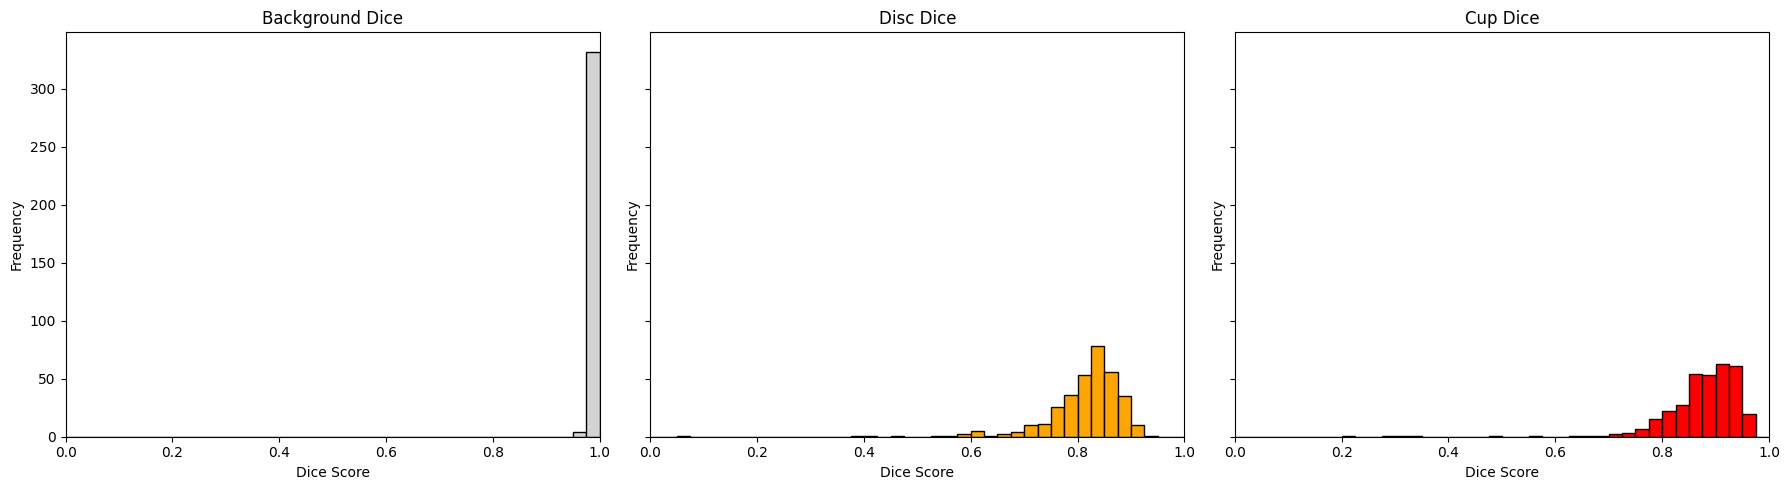

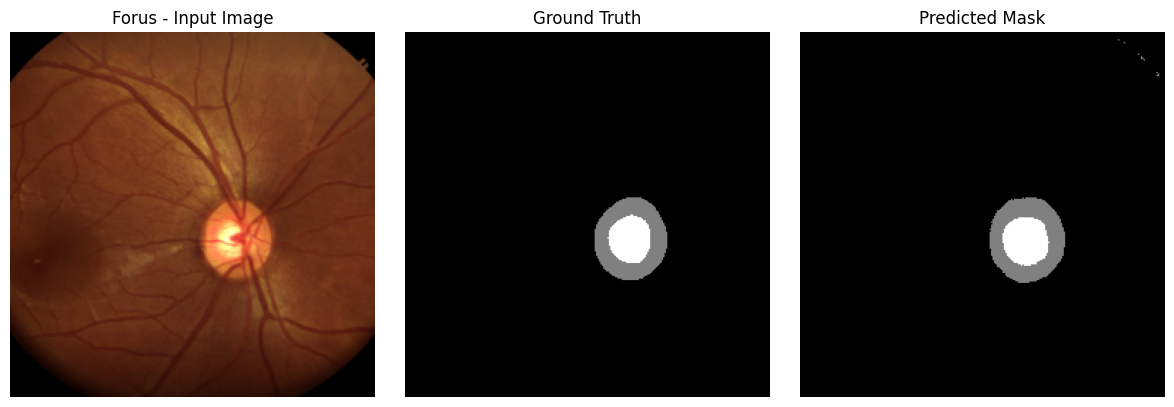

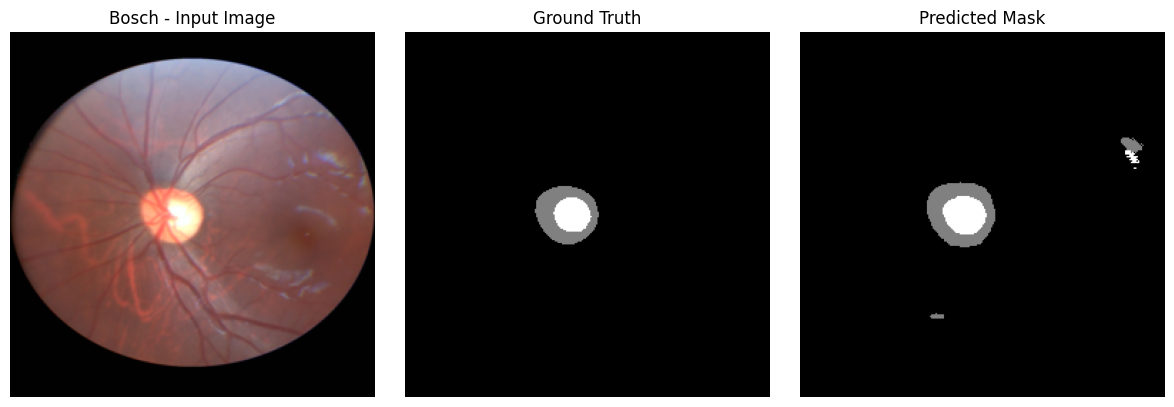

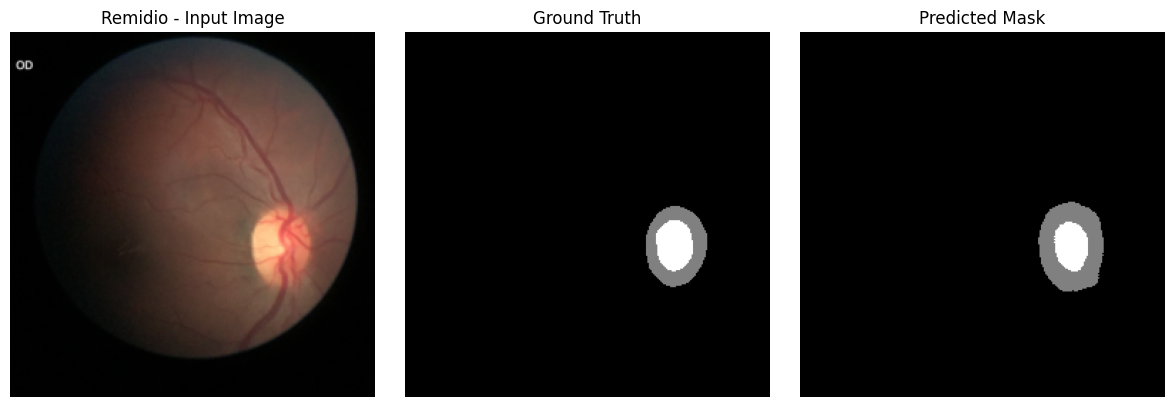

In [ ]:
multitask_test_df = evaluate_multi_model_df(multitask_model, test_loader_all, device)
multitask_test_df.to_csv('multitask_test_df.csv', index=False)
plot_dice_hist(multitask_test_df)
plot_device_examples_multitask(multitask_model, tls)

### Task 4


In [ ]:
# task 4: Solution with explainability markers
'''
Implements Gradient-weighted Class Activation Mapping (Grad-CAM) for visualizing
    class-specific importance regions in the model's decision-making process.
   Grad-CAM   generates heatmaps that highlight areas of the input image
    which contributed most to a specific class prediction, offering interpretability markers for
    how the model attributes each class to the input.


    Attributes:
        model (torch.nn.Module): The PyTorch model to interpret.
        target_layer (torch.nn.Module): The layer from which to extract activations
            and gradients (typically the last convolutional layer).

    Methods:
        generate_cam(input_tensor, target_class_index):
            Performs a forward and backward pass to compute a class-specific heatmap.
            Returns a NumPy array with shape [B, 1, H, W] containing the normalised
             Grad-CAM outputs for each input in the batch.
'''

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer #  target_layer: The layer where gradients/activations are extracted (model.dec1)
        self.gradients = None
        self.activations = None
        # Register hooks to capture activations and gradients
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple; we take the first element (the gradient)
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class_index):
        """
        input_tensor: [B, 3, H, W]
        target_class_index: index of the output class to explain (e.g., 0, 1, or 2, correspondant to our labels)
        """
        self.model.zero_grad()
        # Forward pass (assuming model returns a tuple and first element is logits)
        output = self.model(input_tensor)[0]  # shape: [B, num_classes, H, W]
        # Compute average score over spatial dims for the target class
        target = output[:, target_class_index, :, :].mean()
        target.backward(retain_graph=True)
        # Global average pool the gradients (per channel)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        # Compute weighted combination with activations and sum over channels
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # [B, 1, H, W]
        cam = F.relu(cam)  # only positive contributions

        # Normalize each heatmap to [0,1]
        B, _, H, W = cam.shape
        cam_np = cam.cpu().numpy()
        for i in range(B):
            cam_i = cam_np[i, 0, :, :]
            cam_i -= cam_i.min()
            cam_i /= (cam_i.max() + 1e-8)
            cam_np[i, 0, :, :] = cam_i

        return cam_np



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


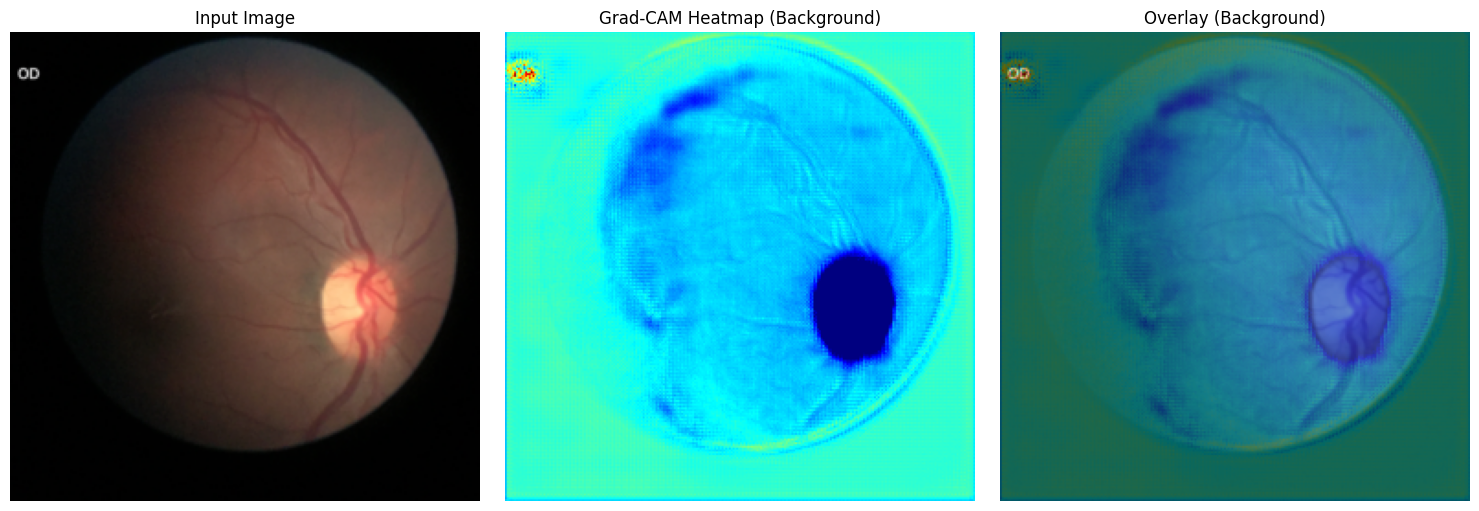

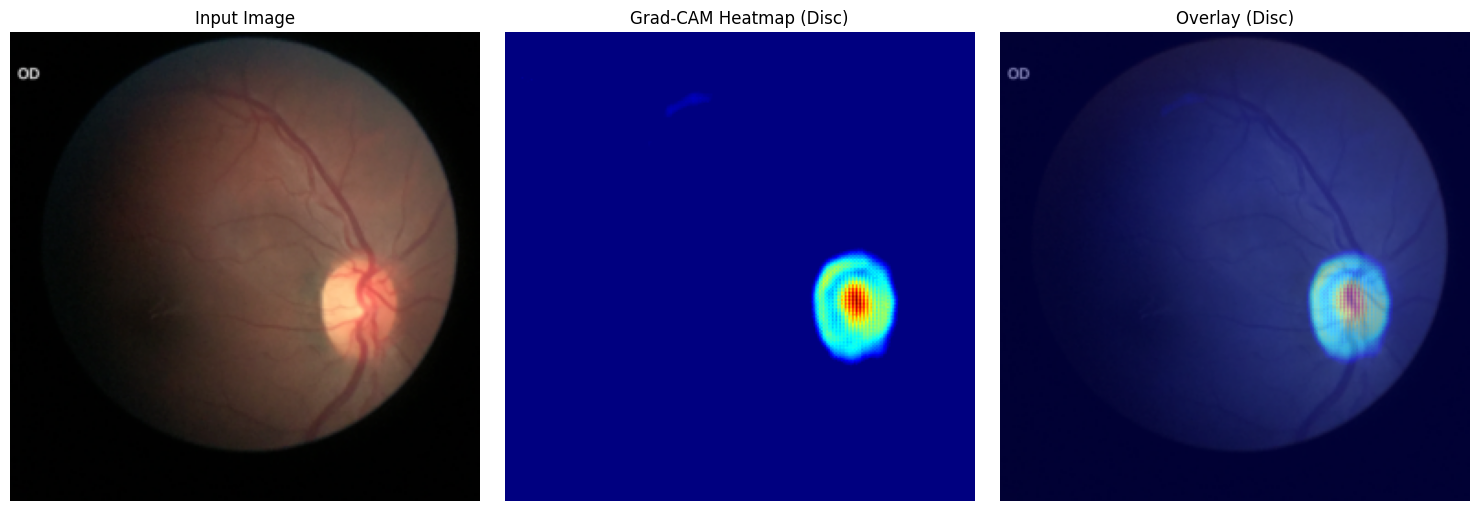

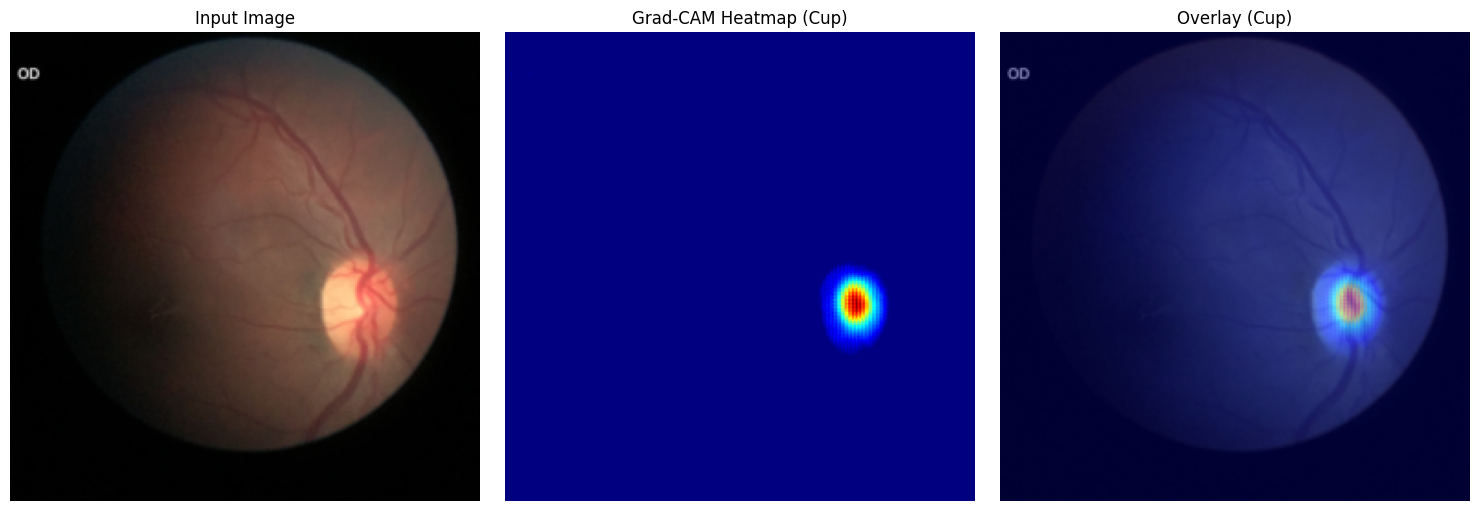

In [ ]:

# Create an instance of GradCAM
grad_cam = GradCAM(baseline_model, baseline_model.dec1)

# change this to be on the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model.to(device)

# Select a sample from your validation loader (make sure input_tensor is [B, 3, H, W])
sample = next(iter(test_loader_Remidio))
input_tensor = sample['image'].to(device)

# Dictionary mapping target class indices to names for readability
class_names = {0: 'Background', 1: 'Disc', 2: 'Cup'}

# Loop over each target class
for target_class, name in class_names.items():
    cams = grad_cam.generate_cam(input_tensor, target_class_index=target_class)
    # For visualisation, we display only the first image in the batch.
    img = input_tensor[0].cpu().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)  # convert to uint8

    # Get the heatmap from Grad-CAM and resize it to the image dimensions
    heatmap = cams[0, 0, :, :]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # generates colour map

    # Overlay heatmap on the input image
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Plot the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_color[:, :, ::-1])
    plt.title(f"Grad-CAM Heatmap ({name})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_img[:, :, ::-1])
    plt.title(f"Overlay ({name})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### Task 5


In [ ]:
# task 5: Solution with bias
'''
Bias with domain generalisation:
We're asessing one of the forms of bias, in this case, from a model trained on a
specific device, and tested on another. We first observe a case where we test on
the overrepresented class is trained on, and it is tested on the two minority cases.
'''
# using remidio_dataset  for training only
# Check the length of the dataset
print(f"Total number of samples in the dataset: {len(remidio_dataset)}")
#  train and validation sets split (80% train, 20% validation)
train_size = int(0.8 * len(remidio_dataset))  # 80% for training
val_size = len(remidio_dataset) - train_size  # 20% for validation
train_dataset_remidio, val_dataset_remidio = random_split(remidio_dataset, [train_size, val_size], generator = generator)

train_loader_remidio = DataLoader(train_dataset_remidio, batch_size=4, shuffle=True, num_workers=12)
val_loader_remidio = DataLoader(val_dataset_remidio, batch_size=4, shuffle=False, num_workers=12)

Total number of samples in the dataset: 810


In [ ]:
remidio_bias_model = ADABN(num_classes=3, num_channels=3)
remidio_bias_model, train_loss_remidio_bias, val_loss_remidio_bias = train_func(remidio_bias_model, train_loader_remidio, val_loader_remidio, class_weights, num_epochs = 10)
torch.save(remidio_bias_model.state_dict(), 'remidio_bias_model.pth')
np.save('val_loss_remidio_bias.npy', np.array(val_loss_remidio_bias))

Model is on device: cuda:0


100%|██████████| 162/162 [00:14<00:00, 11.53it/s]


Avg Dice Scores - Background: 0.9694, Disc: 0.4879, Cup: 0.4669
Epoch [1/10], Training Loss: 0.0030977445015945805, Validation Loss: 0.3090680325176658


100%|██████████| 162/162 [00:14<00:00, 11.56it/s]


Avg Dice Scores - Background: 0.9894, Disc: 0.6315, Cup: 0.6672
Epoch [2/10], Training Loss: 0.001428517603398169, Validation Loss: 0.2572832710859252


100%|██████████| 162/162 [00:13<00:00, 11.60it/s]


Avg Dice Scores - Background: 0.9962, Disc: 0.8001, Cup: 0.8575
Epoch [3/10], Training Loss: 0.0011319970887229858, Validation Loss: 0.18282448409534083


100%|██████████| 162/162 [00:13<00:00, 11.79it/s]


Avg Dice Scores - Background: 0.9968, Disc: 0.8237, Cup: 0.8632
Epoch [4/10], Training Loss: 0.0009717222918071974, Validation Loss: 0.17919810952209844


100%|██████████| 162/162 [00:13<00:00, 11.60it/s]


Avg Dice Scores - Background: 0.9970, Disc: 0.8228, Cup: 0.8797
Epoch [5/10], Training Loss: 0.0008451735120760088, Validation Loss: 0.14444421213574526


100%|██████████| 162/162 [00:13<00:00, 11.70it/s]


Avg Dice Scores - Background: 0.9953, Disc: 0.7557, Cup: 0.8585
Epoch [6/10], Training Loss: 0.0007998625711094876, Validation Loss: 0.14758552265603367


100%|██████████| 162/162 [00:13<00:00, 11.75it/s]


Avg Dice Scores - Background: 0.9965, Disc: 0.8059, Cup: 0.8616
Epoch [7/10], Training Loss: 0.0007712026957789857, Validation Loss: 0.13837479018583532


100%|██████████| 162/162 [00:13<00:00, 11.81it/s]


Avg Dice Scores - Background: 0.9961, Disc: 0.7844, Cup: 0.8690
Epoch [8/10], Training Loss: 0.0007557604312010971, Validation Loss: 0.13344855733760974


100%|██████████| 162/162 [00:14<00:00, 11.56it/s]


Avg Dice Scores - Background: 0.9966, Disc: 0.7808, Cup: 0.8564
Epoch [9/10], Training Loss: 0.0007094861713851703, Validation Loss: 0.14405103209542064


100%|██████████| 162/162 [00:13<00:00, 11.71it/s]


Avg Dice Scores - Background: 0.9957, Disc: 0.7864, Cup: 0.8578
Epoch [10/10], Training Loss: 0.0006628501555611131, Validation Loss: 0.12409188980009497
Best model restored.


Total number of samples in the combined dataset: 72


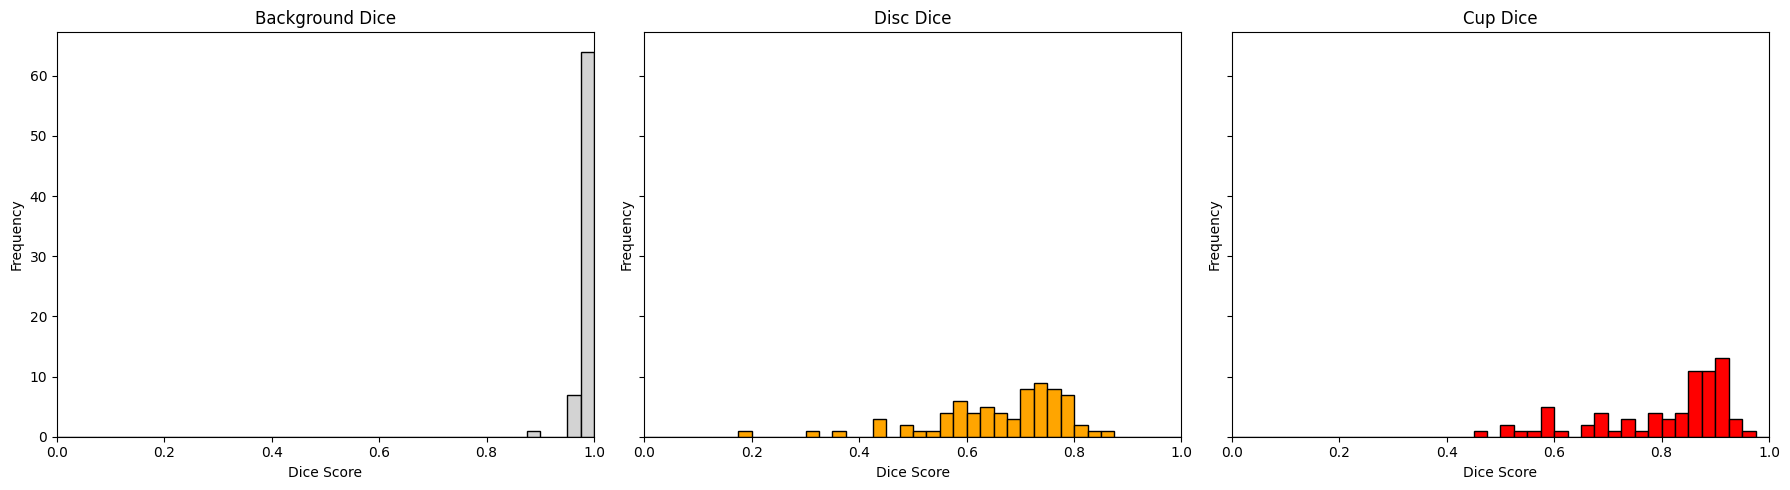

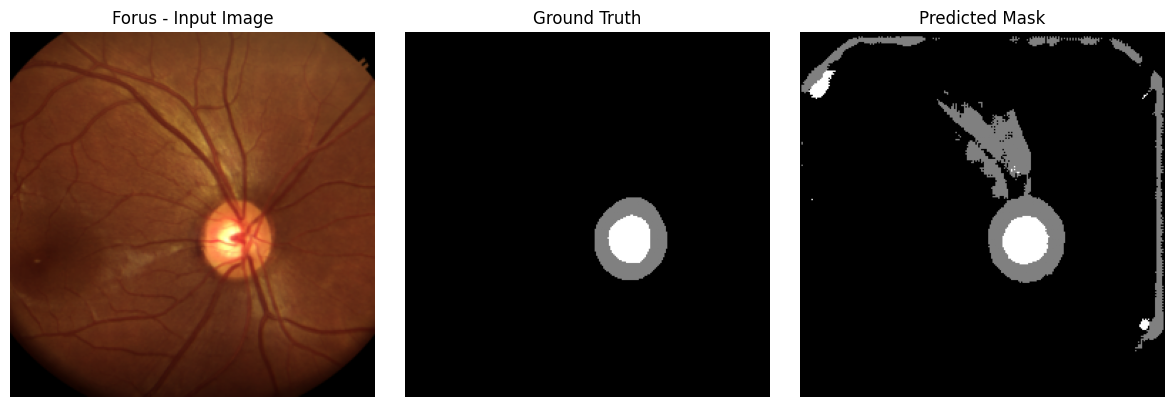

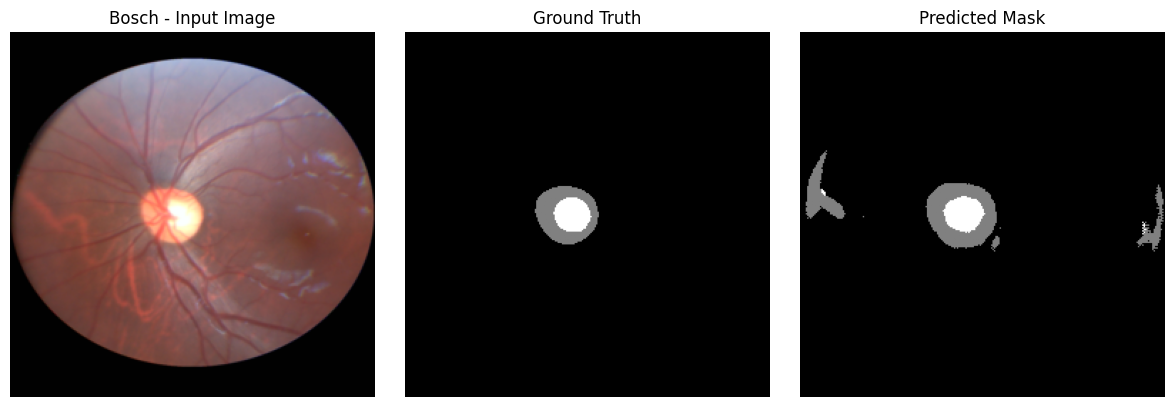

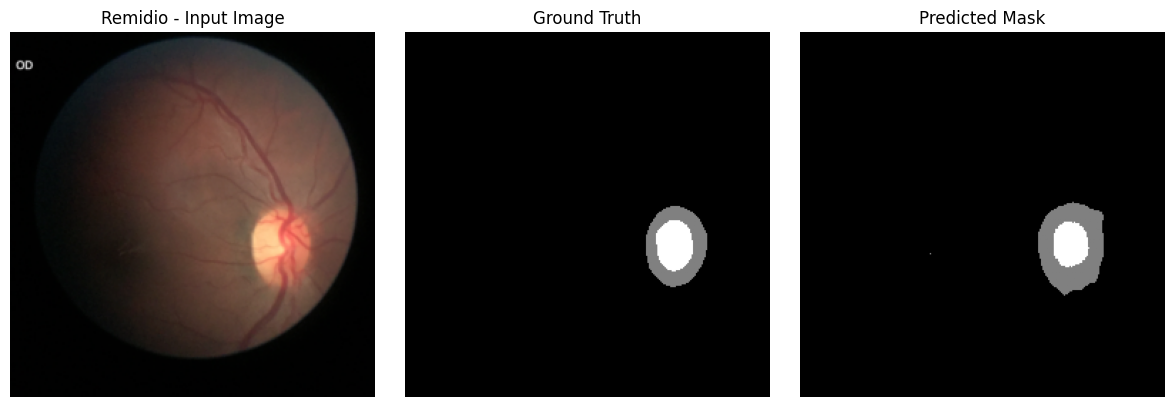

In [ ]:
# 8. Define the test loop on the test set of the other two datasets
test_dataset_nonRemidio = ConcatDataset([test_bosch_dataset, test_forus_dataset])
test_loader_nonRemidio = DataLoader(test_dataset_nonRemidio, batch_size=4, shuffle=False, num_workers=12)
# Check the length of the combined dataset
print(f"Total number of samples in the combined dataset: {len(test_dataset_nonRemidio)}")

remidio_bias_test_df = evaluate_segmentation_model_df(remidio_bias_model, test_loader_nonRemidio, device)
remidio_bias_test_df.to_csv('remidio_bias_test_df.csv', index=False)
plot_dice_hist(remidio_bias_test_df)
plot_device_examples(remidio_bias_model, tls)

In [ ]:
'''
we assess how the model performs when tested on the most represented model on
the Chaksu dataset (trained
on least represented devuce)
'''
# what if training on the lowest representation and testing on the highest representation
# using forus_dataset  for training only

# Check the length of the dataset
print(f"Total number of samples in the dataset: {len(forus_dataset)}")
#  train and validation sets split (80% train, 20% validation)
train_size_forus = int(0.8 * len(forus_dataset))  # 80% for training
val_size_forus = len(forus_dataset) - train_size_forus  # 20% for validation
train_dataset_forus, val_dataset_forus = random_split(forus_dataset, [train_size_forus, val_size_forus])
# number of train and val
print(len(train_dataset_forus))
print(len(val_dataset_forus))

train_loader_forus = DataLoader(train_dataset_forus, batch_size=4, shuffle=True, num_workers=12)
val_loader_forus = DataLoader(val_dataset_forus, batch_size=4, shuffle=False, num_workers=12)

Total number of samples in the dataset: 95
76
19


In [ ]:
forus_bias_model = ADABN(num_classes=3, num_channels=3)
forus_bias_model, train_loss_forus_bias, val_loss_forus_bias = train_func(forus_bias_model, train_loader_forus, val_loader_forus, class_weights, num_epochs = 10)
torch.save(forus_bias_model.state_dict(), 'forus_bias_model.pth')
np.save('val_loss_forus_bias.npy', np.array(val_loss_forus_bias))

Model is on device: cuda:0


100%|██████████| 19/19 [00:01<00:00, 10.57it/s]


Avg Dice Scores - Background: 0.7396, Disc: 0.1391, Cup: 0.0248
Epoch [1/10], Training Loss: 0.051587633644114575, Validation Loss: 0.8280222654342652


100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Avg Dice Scores - Background: 0.8367, Disc: 0.1804, Cup: 0.0964
Epoch [2/10], Training Loss: 0.03442574884752818, Validation Loss: 0.7448884963989257


100%|██████████| 19/19 [00:01<00:00, 10.76it/s]


Avg Dice Scores - Background: 0.8707, Disc: 0.2029, Cup: 0.2470
Epoch [3/10], Training Loss: 0.02506428189224814, Validation Loss: 0.49730175733566284


100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


Avg Dice Scores - Background: 0.9151, Disc: 0.2840, Cup: 0.2999
Epoch [4/10], Training Loss: 0.019561912461991456, Validation Loss: 0.4710074007511139


100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Avg Dice Scores - Background: 0.9393, Disc: 0.3052, Cup: 0.4128
Epoch [5/10], Training Loss: 0.017497424191054874, Validation Loss: 0.46243542432785034


100%|██████████| 19/19 [00:01<00:00, 10.31it/s]


Avg Dice Scores - Background: 0.9574, Disc: 0.4145, Cup: 0.5124
Epoch [6/10], Training Loss: 0.014930835886345015, Validation Loss: 0.421216094493866


100%|██████████| 19/19 [00:01<00:00, 10.78it/s]


Avg Dice Scores - Background: 0.9685, Disc: 0.4566, Cup: 0.5672
Epoch [7/10], Training Loss: 0.013449231921140507, Validation Loss: 0.3725505232810974


100%|██████████| 19/19 [00:01<00:00, 10.63it/s]


Avg Dice Scores - Background: 0.9740, Disc: 0.5156, Cup: 0.7111
Epoch [8/10], Training Loss: 0.012324647394904138, Validation Loss: 0.3383213847875595


100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


Avg Dice Scores - Background: 0.9822, Disc: 0.5685, Cup: 0.7016
Epoch [9/10], Training Loss: 0.011162721879594545, Validation Loss: 0.3252977132797241


100%|██████████| 19/19 [00:01<00:00,  9.95it/s]


Avg Dice Scores - Background: 0.9818, Disc: 0.5974, Cup: 0.7452
Epoch [10/10], Training Loss: 0.010192516850632645, Validation Loss: 0.3882043480873108
Best model restored.


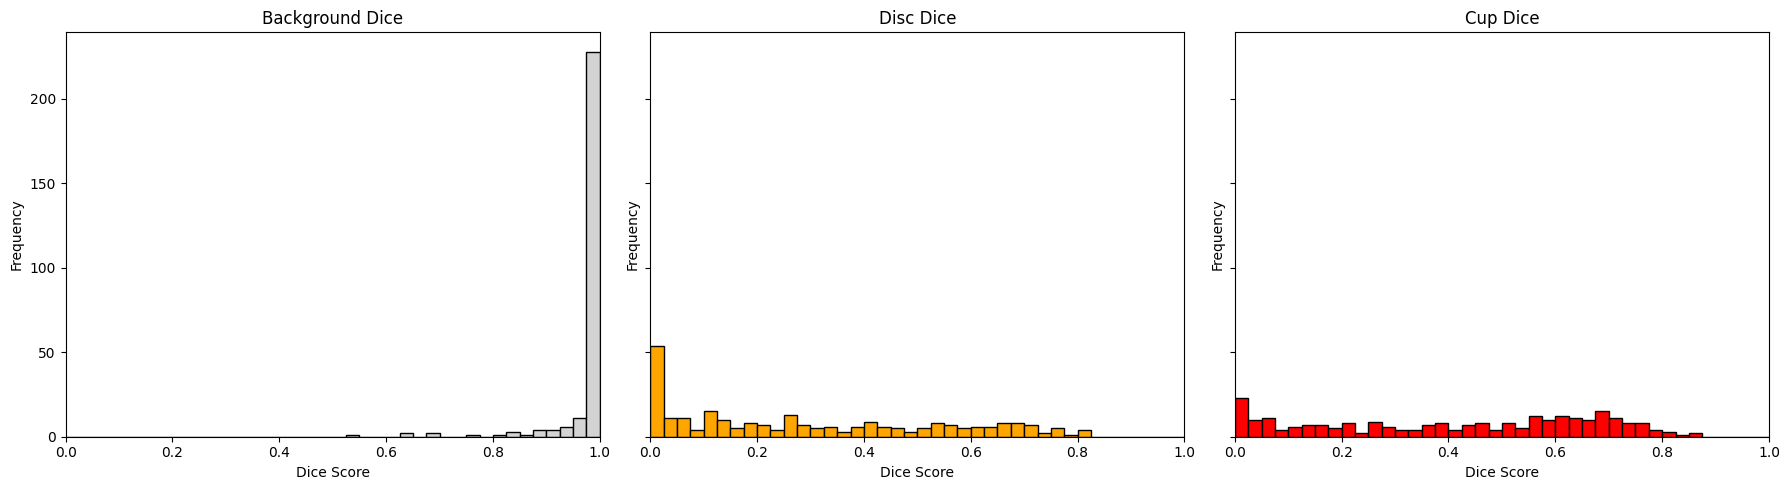

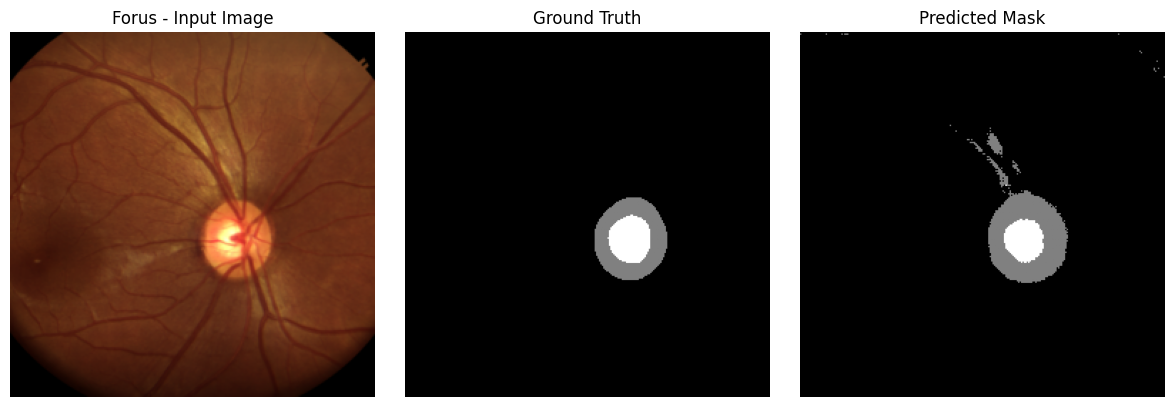

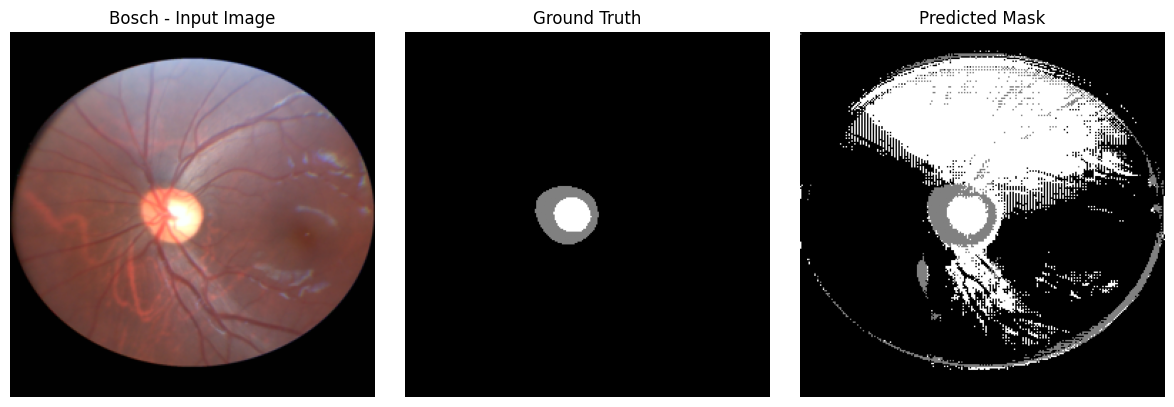

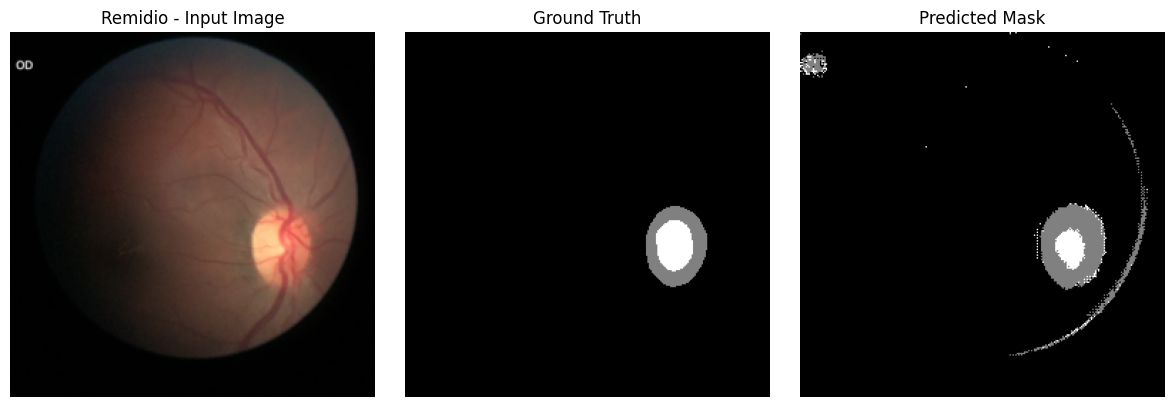

In [ ]:
forus_bias_test_df = evaluate_segmentation_model_df(forus_bias_model, test_loader_Remidio, device)
forus_bias_test_df.to_csv('forus_bias_test_df.csv', index=False)
plot_dice_hist(forus_bias_test_df)
plot_device_examples(forus_bias_model, tls)

### Task 6

In [ ]:
# task 6: Solution incorporating uncertainty evaluation

In [ ]:
def mc_dropout_inference(model, images, T=5):
    """
    model:  ADABN with dropout
    images: [B, C, H, W]
    T: number of stochastic forward passes
    Returns:
      mean_probs  - [B, 3, H, W] average predicted probabilities
      pred_entropy - [B, H, W] predictive entropy
    """
    # Keep dropout active at inference
    model.train()
    preds_list = []
    with torch.no_grad():
        for _ in range(T):
            logits = model(images)[0]
            probs  = F.softmax(logits, dim=1)    # => [B,3,H,W]
            preds_list.append(probs.unsqueeze(0))# => [1,B,3,H,W]
    # Stack => [T,B,3,H,W]
    stacked = torch.cat(preds_list, dim=0)
    # Mean probability
    mean_probs = stacked.mean(dim=0)  # => [B,3,H,W]
    # Pixelwise predictive entropy
    pred_entropy = -(mean_probs * mean_probs.log()).sum(dim=1) # => [B,H,W]

    return mean_probs, pred_entropy

In [ ]:
def evaluate_uncertainty_model_df(model, test_loader, T=5, num_classes=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)

    sample_records = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            mean_probs, pred_entropy = mc_dropout_inference(model, images, T=5)
            preds = mean_probs.argmax(dim=1) # shape [B,H,W]

            for i in range(images.shape[0]):
                pred_i = preds[i]
                label_i = labels[i]

                # Compute Dice score
                dice_scores = dice_score_per_class(pred_i, label_i, num_classes)
                # added hd95
                hd95_scores = []
                pred_np = pred_i.cpu().numpy()
                label_np = label_i.cpu().numpy()

                for cls in range(num_classes):
                    pred_mask = (pred_np == cls)
                    label_mask = (label_np == cls)
                    hd = compute_hd95(pred_mask, label_mask)
                    hd95_scores.append(hd)

                # Metadata
                image_name = batch["info"]["key"][i]
                device_name = batch["info"]["device"][i]
                status_label = batch["info"]["majority_decision"][i]
                status_str = "Glaucoma" if status_label == 1 else "Normal"

                sample_records.append({
                    "image_name": image_name,
                    "device_name": device_name,
                    "glaucoma_status": status_str,
                    "dice_background": dice_scores[0],
                    "dice_disc": dice_scores[1],
                    "dice_cup": dice_scores[2],
                    "hd95_background": hd95_scores[0],
                    "hd95_disc": hd95_scores[1],
                    "hd95_cup": hd95_scores[2],
                })

    df = pd.DataFrame(sample_records)
    return df

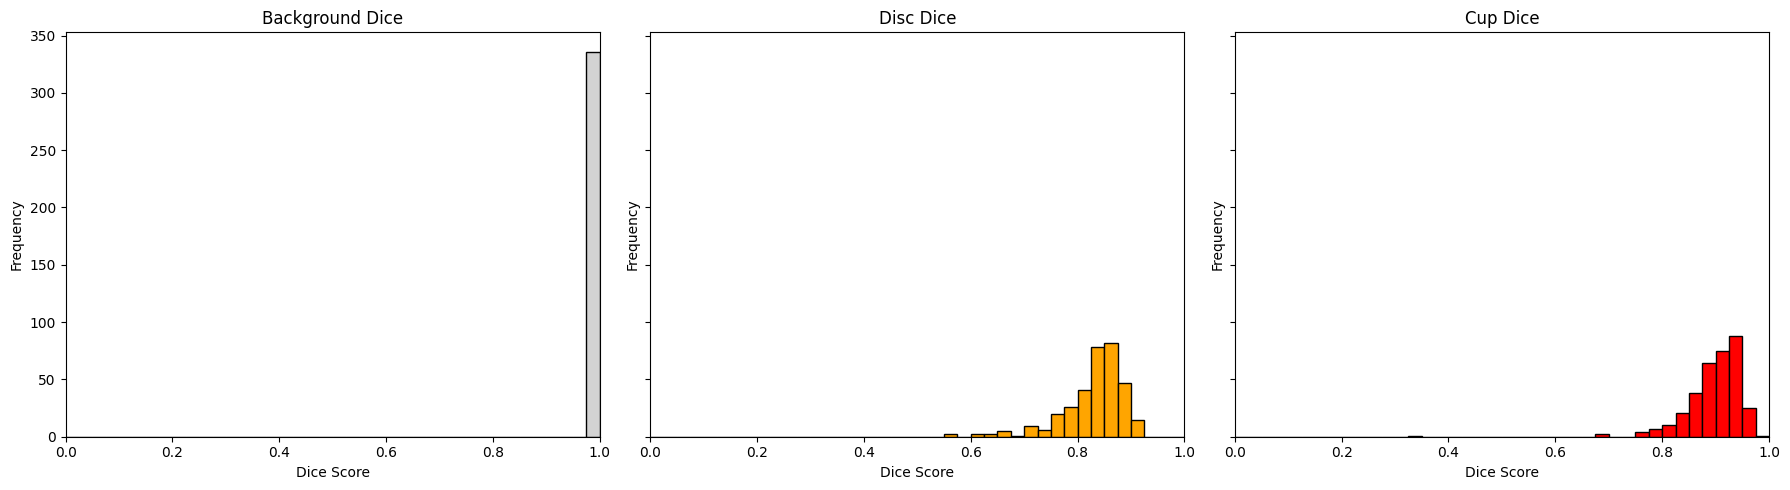

In [ ]:
uncertainty_test_df = evaluate_uncertainty_model_df(baseline_model, test_loader_all, T=5)
uncertainty_test_df.to_csv('uncertainty_test_df.csv', index=False)
plot_dice_hist(uncertainty_test_df)

MC Dropout => final_seg shape: torch.Size([4, 256, 256])
MC Dropout => entropy shape:    torch.Size([4, 256, 256])


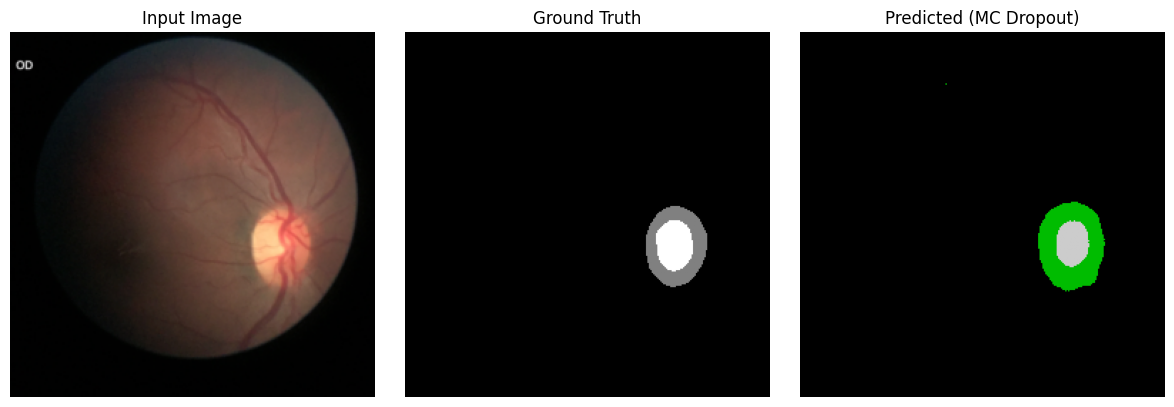

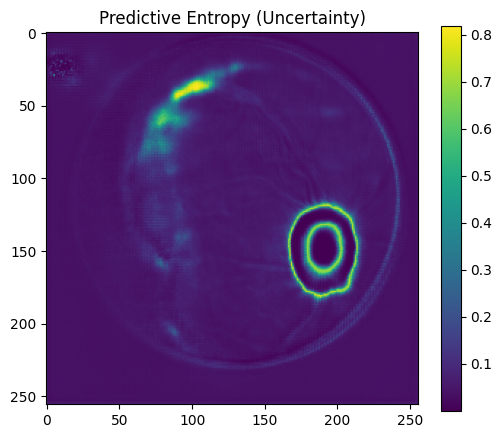

In [ ]:
# MC-Dropout Inference Example:
dataiter = iter(test_loader_all)
batch = next(dataiter)
test_imgs = batch['image'].to(device) # shape [B,3,256,256]
# We do multiple forward passes
mean_probs, pred_entropy = mc_dropout_inference(baseline_model, test_imgs, T=5)
final_seg = mean_probs.argmax(dim=1) # shape [B,H,W]

print("MC Dropout => final_seg shape:", final_seg.shape)
print("MC Dropout => entropy shape:   ", pred_entropy.shape)

# Visualise the first sample
plt.figure(figsize=(12,4))
# Input
plt.subplot(1,3,1)
# Move from GPU -> CPU -> Numpy
img_show = test_imgs[0].cpu().permute(1,2,0).numpy()
plt.imshow(img_show)
plt.title("Input Image")
plt.axis('off')

# Ground truth
plt.subplot(1,3,2)
gt = batch['label'][0].cpu().numpy()
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

# Predicted seg
plt.subplot(1,3,3)
seg_show = final_seg[0].cpu().numpy()
plt.imshow(seg_show, cmap='nipy_spectral')
plt.title("Predicted (MC Dropout)")
plt.axis('off')

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# pred_entropy has shape [B, H, W]. Visualise the first image in the batch
uncert_map = pred_entropy[0].cpu().numpy()

plt.figure(figsize=(6,5))
plt.imshow(uncert_map, cmap='viridis')
plt.colorbar()
plt.title("Predictive Entropy (Uncertainty)")
plt.show()


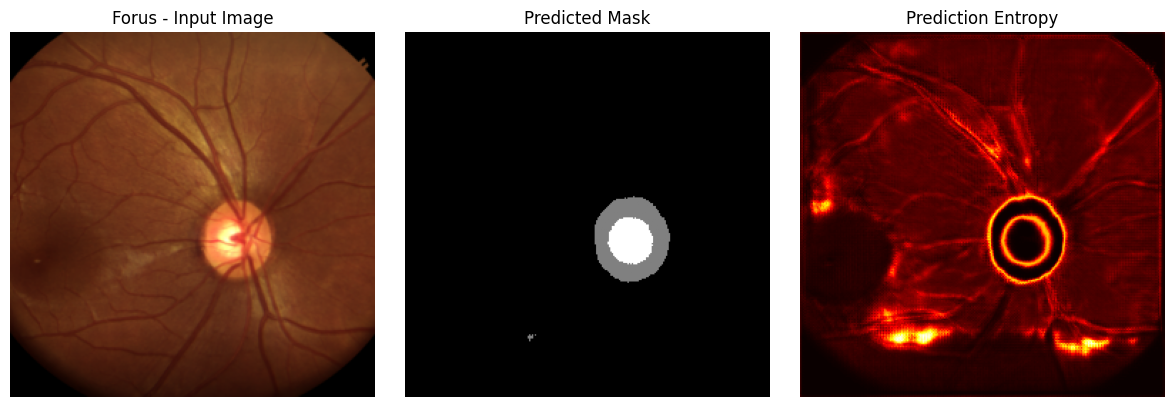

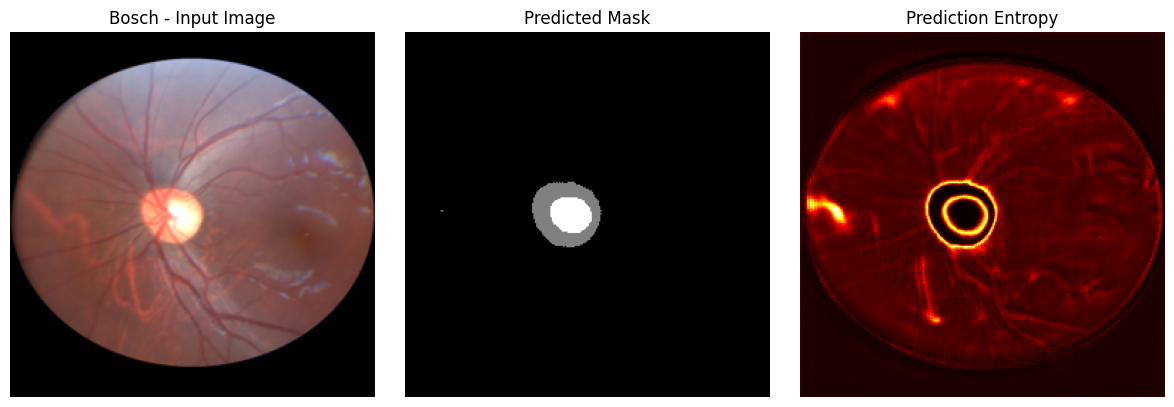

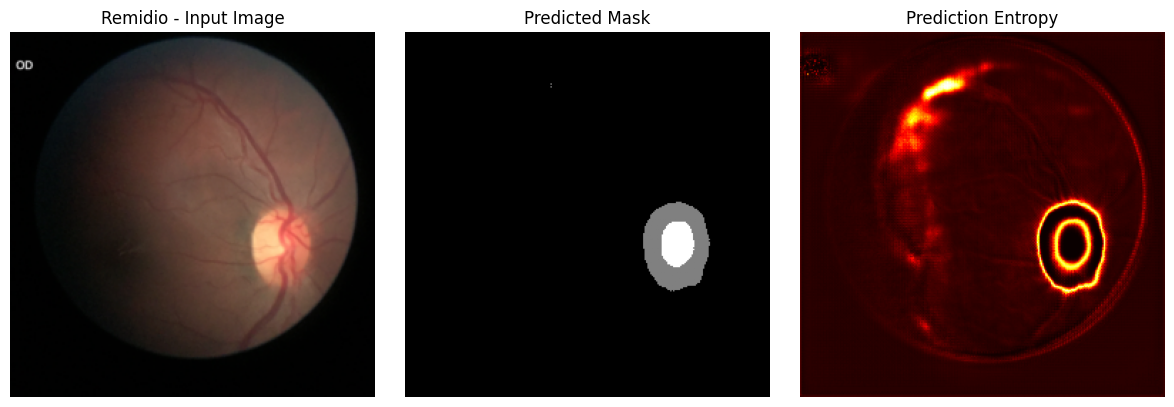

In [ ]:
def plot_device_examples_unc(model, tls, T=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()

    with torch.no_grad():
        for device_name, loader in tls.items():
            sample = next(iter(loader))  # first batch
            images = sample['image'].to(device)

            preds_list = []
            for _ in range(T):
                outputs = model(images)[0]
                probs = F.softmax(outputs, dim=1)    # => [B,3,H,W]
                preds_list.append(probs.unsqueeze(0))   # => [1,B,3,H,W]

            # Stack => [T,B,3,H,W]
            stacked_preds = torch.cat(preds_list, dim=0)
            # Mean probability
            mean_probs = stacked_preds.mean(dim=0)  # => [B,3,H,W]
            preds = mean_probs.argmax(dim=1) # shape [B,H,W]
            pred_entropy = -(mean_probs * mean_probs.log()).sum(dim=1) # => [B,H,W]

            i = 0  # show the first image

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(images[i].cpu().permute(1, 2, 0))
            axs[0].set_title(f"{device_name} - Input Image")
            axs[0].axis("off")

            axs[1].imshow(preds[i].cpu(), cmap="gray")
            axs[1].set_title("Predicted Mask")
            axs[1].axis("off")

            axs[2].imshow(pred_entropy[i].cpu(), cmap="hot")
            axs[2].set_title("Prediction Entropy")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

plot_device_examples_unc(baseline_model, tls, T=5)

In [ ]:
import numpy as np
import torch

def uncertainty_error_overlap(final_seg, pred_entropy, labels):
    """
    final_seg:   [B,H,W] argmax segmentation from mean_probs
    pred_entropy:[B,H,W] pixelwise uncertainty
    labels:      [B,H,W] ground-truth
    Returns: a dictionary with statistics:
             - fraction_of_pixels_needed at various thresholds
             - fraction_of_errors_covered
    """
    # Flatten all pixels across the batch:
    final_seg_flat = final_seg.view(-1).cpu().numpy()
    entropy_flat   = pred_entropy.view(-1).cpu().numpy()
    labels_flat    = labels.view(-1).cpu().numpy()

    # Error mask: 1 if final_seg != labels
    error_mask = (final_seg_flat != labels_flat).astype(np.int32)

    # Sort all pixels by descending entropy
    sorted_indices = np.argsort(-entropy_flat)
    sorted_entropy = entropy_flat[sorted_indices]
    sorted_errors  = error_mask[sorted_indices]

    # Measure coverage at various top-% intervals
    coverage_fractions = [0.01, 0.02, 0.05, 0.10, 0.20]
    results = {}
    n_pixels = len(sorted_entropy)
    n_errors = sorted_errors.sum()

    for frac in coverage_fractions:
        # how many top pixels does that fraction correspond to?
        top_k = int(frac * n_pixels)
        # how many errors are in top_k?
        errors_in_topk = sorted_errors[:top_k].sum()
        # fraction of errors covered
        frac_error_covered = errors_in_topk / (n_errors if n_errors>0 else 1)
        results[frac] = {
            'num_pixels_in_top': top_k,
            'errors_in_topk': int(errors_in_topk),
            'fraction_errors_covered': frac_error_covered
        }

    return results


mean_probs, pred_entropy = mc_dropout_inference(uncertainty_model, test_imgs, T=5)
final_seg = mean_probs.argmax(dim=1)  # [B,H,W]
labels    = batch['label']           # [B,H,W]
stats = uncertainty_error_overlap(final_seg, pred_entropy, labels)
print(stats)


{0.01: {'num_pixels_in_top': 2621, 'errors_in_topk': 775, 'fraction_errors_covered': np.float64(0.7019927536231884)}, 0.02: {'num_pixels_in_top': 5242, 'errors_in_topk': 897, 'fraction_errors_covered': np.float64(0.8125)}, 0.05: {'num_pixels_in_top': 13107, 'errors_in_topk': 960, 'fraction_errors_covered': np.float64(0.8695652173913043)}, 0.1: {'num_pixels_in_top': 26214, 'errors_in_topk': 985, 'fraction_errors_covered': np.float64(0.8922101449275363)}, 0.2: {'num_pixels_in_top': 52428, 'errors_in_topk': 997, 'fraction_errors_covered': np.float64(0.9030797101449275)}}


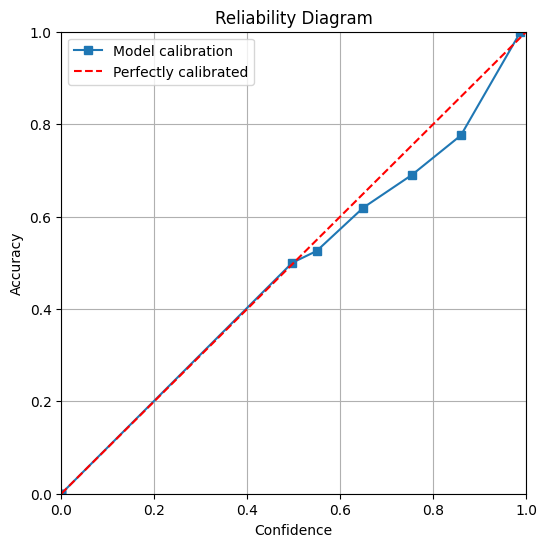

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def reliability_diagram(mean_probs, labels, num_bins=10):
    """
    mean_probs: [B,C,H,W] (C=3 classes). Probability distribution over classes
    labels:     [B,H,W] ground truth
    num_bins:   how many bins to segment confidence
    Returns a figure or data for reliability diagram
    """
    # Flatten
    B, C, H, W = mean_probs.shape
    mean_probs_flat = mean_probs.permute(0,2,3,1).reshape(-1, C).cpu().numpy() # => [N, C]
    labels_flat     = labels.view(-1).cpu().numpy()                            # => [N]

    # For each pixel, predicted class is argmax, predicted confidence is max prob
    pred_confidences = mean_probs_flat.max(axis=1)          # => [N]
    pred_classes      = mean_probs_flat.argmax(axis=1)      # => [N]
    correct_mask      = (pred_classes == labels_flat).astype(np.float32)

    # Bin pixels by predicted confidence
    bin_edges = np.linspace(0, 1, num_bins+1)
    bin_indices = np.digitize(pred_confidences, bin_edges) - 1

    bin_acc = np.zeros(num_bins, dtype=np.float32)  # average accuracy in that bin
    bin_conf= np.zeros(num_bins, dtype=np.float32)  # average confidence in that bin
    bin_count= np.zeros(num_bins, dtype=np.float32)

    for i in range(num_bins):
        # find pixels that fell into bin i
        mask = (bin_indices == i)
        count = mask.sum()
        if count > 0:
            bin_count[i] = count
            bin_acc[i]   = correct_mask[mask].mean()
            bin_conf[i]  = pred_confidences[mask].mean()
        else:
            bin_acc[i]   = 0
            bin_conf[i]  = 0

    # overall normalisation
    bin_frac = bin_count / bin_count.sum()  # fraction of pixels in each bin

    return bin_conf, bin_acc, bin_frac


def plot_reliability_diagram(bin_conf, bin_acc):
    """
    bin_conf: average confidence in each bin
    bin_acc:  average accuracy in that bin
    """
    plt.figure(figsize=(6,6))
    plt.plot(bin_conf, bin_acc, 's-', label='Model calibration')
    plt.plot([0,1], [0,1], 'r--', label='Perfectly calibrated')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True)
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.show()


mean_probs, pred_entropy = mc_dropout_inference(uncertainty_model, test_imgs, T=5)
labels = batch['label'].to(device)
bin_conf, bin_acc, bin_frac = reliability_diagram(mean_probs, labels, num_bins=10)
plot_reliability_diagram(bin_conf, bin_acc)


### Task 7

Multitask model

In [ ]:
from collections import defaultdict
import torch
from torch.utils.data import WeightedRandomSampler

def make_balanced_weights_by_group(subset):
    """
    Returns per-sample weights balancing across:
    - Device (e.g. Forus, Bosch, Remidio)
    - Glaucoma status (0 or 1)
    """
    base_dataset = subset.dataset
    indices = subset.indices

    device_to_indices = defaultdict(list)
    status_to_indices = defaultdict(list)

    for global_idx in indices:
        sub_ds_idx, local_idx = dataset_index_for_concat(base_dataset, global_idx)
        sub_ds = base_dataset.datasets[sub_ds_idx]
        device, status = sub_ds.get_group_labels()[local_idx]  # (device_name, 0/1)

        device_to_indices[device].append(global_idx)
        status_to_indices[status].append(global_idx)

    # Assign per-sample weights: mean of (1 / group_size) for device and Glaucoma status
    sample_weights = [0.0] * len(base_dataset)

    for group_dict in [device_to_indices, status_to_indices]:
        for group, group_indices in group_dict.items():
            w = 1.0 / len(group_indices)
            for idx in group_indices:
                sample_weights[idx] += w  # accumulate from both groups

    # Average (i.e. mean of 2 groupings)
    for i in range(len(sample_weights)):
        sample_weights[i] /= 2.0

    # Return weights for the actual subset
    subset_weights = torch.DoubleTensor([sample_weights[i] for i in indices])
    return subset_weights

In [ ]:
#Generate weights and make sampler
weights = make_balanced_weights_by_group(train_dataset)
print(len(weights))

train_sampler_mix = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True
)

# Wrap the train subset in the AugmentWrapper so it applies random flips, etc.
train_dataset_mix = AugmentWrapper(train_dataset, p_hflip=0.5, p_vflip=0.2)
val_dataset_mix   = val_dataset  # no augmentation

train_loader_mix = DataLoader(
    dataset=train_dataset_mix,
    batch_size=4,
    sampler=train_sampler_mix,
    num_workers=12
)

val_loader_mix = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=12
)

807


In [ ]:
#Train mixture model with multitask architecture
mix_model  = MultiTaskUNet(num_classes=3, in_channels=3)
mix_model, train_loss_list_mix, val_total_loss_list_mix, \
  val_loss_list_seg_mix, val_loss_list_class_mix, \
  val_loss_list_reg_mix = train_multitask_model(
    model=mix_model,
    t_loader=train_loader_mix,
    v_loader=val_loader_mix,
    class_weights = class_weights,
    glauc_weight = torch.tensor([1], device=device),
    num_epochs=10,
    lambda_seg=5,
    lambda_cls=1.0,
    lambda_reg=5
)
np.save('val_loss_mix_total.npy', np.array(val_total_loss_list_mix))
np.save('val_loss_mix_seg.npy', np.array(val_loss_list_seg_mix))
np.save('val_loss_mix_class.npy', np.array(val_loss_list_class_mix))
np.save('val_loss_mix_reg.npy', np.array(val_loss_list_reg_mix))
torch.save(mix_model.state_dict(), 'mix_model.pth')

Model is on device: cuda:0


100%|██████████| 202/202 [00:13<00:00, 15.25it/s]


Avg Dice Scores - Background: 0.9866, Disc: 0.6338, Cup: 0.6234
Epoch [1/10], Training Loss: 0.014266147784492148, Validation Total Loss: 1.84651377621819
Validation Seg Loss: 0.2627883129844479, Validation Cls Loss: 0.48326004778637605, Validation Reg Loss: 0.009862429930317197


100%|██████████| 202/202 [00:12<00:00, 15.57it/s]


Avg Dice Scores - Background: 0.9943, Disc: 0.7317, Cup: 0.8334
Epoch [2/10], Training Loss: 0.008476940377613292, Validation Total Loss: 1.5500613591250252
Validation Seg Loss: 0.2040858680711073, Validation Cls Loss: 0.4810473509863311, Validation Reg Loss: 0.009716933410541684


100%|██████████| 202/202 [00:13<00:00, 15.32it/s]


Avg Dice Scores - Background: 0.9966, Disc: 0.7886, Cup: 0.8742
Epoch [3/10], Training Loss: 0.007797795069321688, Validation Total Loss: 1.3322378841100955
Validation Seg Loss: 0.16459281377348245, Validation Cls Loss: 0.46897004223337363, Validation Reg Loss: 0.008060753870499777


100%|██████████| 202/202 [00:13<00:00, 14.95it/s]


Avg Dice Scores - Background: 0.9970, Disc: 0.8023, Cup: 0.8704
Epoch [4/10], Training Loss: 0.0069974319626450385, Validation Total Loss: 1.205469464554506
Validation Seg Loss: 0.14467964730426378, Validation Cls Loss: 0.43002571808356865, Validation Reg Loss: 0.010409101364476717


100%|██████████| 202/202 [00:13<00:00, 15.34it/s]


Avg Dice Scores - Background: 0.9971, Disc: 0.8187, Cup: 0.8664
Epoch [5/10], Training Loss: 0.0066495226500209855, Validation Total Loss: 1.2705066916989345
Validation Seg Loss: 0.148144182621264, Validation Cls Loss: 0.48524201003944173, Validation Reg Loss: 0.008908754469160283


100%|██████████| 202/202 [00:13<00:00, 14.87it/s]


Avg Dice Scores - Background: 0.9962, Disc: 0.7955, Cup: 0.8481
Epoch [6/10], Training Loss: 0.006378287363842345, Validation Total Loss: 1.1134456664908166
Validation Seg Loss: 0.13861095613124325, Validation Cls Loss: 0.3769029162678064, Validation Reg Loss: 0.008697593598352635


100%|██████████| 202/202 [00:12<00:00, 15.60it/s]


Avg Dice Scores - Background: 0.9949, Disc: 0.7631, Cup: 0.8149
Epoch [7/10], Training Loss: 0.006016715997317856, Validation Total Loss: 1.0589222382096684
Validation Seg Loss: 0.12785057825785057, Validation Cls Loss: 0.3809165297185673, Validation Reg Loss: 0.007750563181973263


100%|██████████| 202/202 [00:13<00:00, 15.45it/s]


Avg Dice Scores - Background: 0.9966, Disc: 0.8003, Cup: 0.8662
Epoch [8/10], Training Loss: 0.006259442285782753, Validation Total Loss: 1.110479149163938
Validation Seg Loss: 0.12809358946248597, Validation Cls Loss: 0.43450189162703123, Validation Reg Loss: 0.007101861648170241


100%|██████████| 202/202 [00:13<00:00, 15.17it/s]


Avg Dice Scores - Background: 0.9948, Disc: 0.7819, Cup: 0.8075
Epoch [9/10], Training Loss: 0.005574437706812423, Validation Total Loss: 1.0331707783773834
Validation Seg Loss: 0.13513446803770812, Validation Cls Loss: 0.30972203992161096, Validation Reg Loss: 0.00955527986618964


100%|██████████| 202/202 [00:13<00:00, 15.51it/s]


Avg Dice Scores - Background: 0.9975, Disc: 0.8344, Cup: 0.8950
Epoch [10/10], Training Loss: 0.005487358598729674, Validation Total Loss: 1.017895214697894
Validation Seg Loss: 0.11903913552854575, Validation Cls Loss: 0.3837527103868185, Validation Reg Loss: 0.007789365536368945
Best model restored.


In [ ]:
#Evaluate mixture model with uncertainty estimation and majority vote from X (e.g. 5) forward passes
def evaluate_multi_unc_model_df(model, test_loader, T=5, num_classes=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    model.to(device)

    sample_records = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            glaucoma_labels = batch['info']['majority_decision'].float().unsqueeze(1)
            # Stack Cup Area and Disc Area for regression
            area_targets = torch.stack([
                batch['info']['ACDR'],
                batch['info']['VCDR'],
                batch['info']['HCDR']
            ], dim=1).cpu().numpy()

            preds_list = []
            area_preds_list = []
            glaucoma_preds_list = []
            for _ in range(T):
                outputs = model(images)
                seg_logits = outputs['segmentation']
                glaucoma_logits = outputs['glaucoma_class']
                area_preds = outputs['area_preds']

                probs = F.softmax(seg_logits, dim=1)    # => [B,3,H,W]
                preds_list.append(probs.unsqueeze(0))   # => [1,B,3,H,W]

                area_preds_list.append(area_preds.unsqueeze(0))

                glaucoma_probs = torch.sigmoid(glaucoma_logits)
                glaucoma_preds_list.append(glaucoma_probs.unsqueeze(0))

            # Stack => [T,B,3,H,W]
            stacked_preds = torch.cat(preds_list, dim=0)
            stacked_area_preds = torch.cat(area_preds_list, dim=0)
            stacked_glaucoma_preds = torch.cat(glaucoma_preds_list, dim=0)
            # Mean probability
            mean_probs = stacked_preds.mean(dim=0)  # => [B,3,H,W]
            preds = mean_probs.argmax(dim=1) # shape [B,H,W]

            area_preds = stacked_area_preds.mean(dim=0)

            mean_glaucoma_probs = stacked_glaucoma_preds.mean(dim=0)
            glaucoma_preds = (mean_glaucoma_probs > 0.5).long()

            for i in range(images.shape[0]):
                pred_i = preds[i]
                label_i = labels[i]
                glauc_label_i = glaucoma_labels[i]
                area_preds_i = area_preds[i]
                area_targets_i = area_targets[i]

                # Compute Dice score
                dice_scores = dice_score_per_class(pred_i, label_i, num_classes)
                # added hd95
                hd95_scores = []
                pred_np = pred_i.cpu().numpy()
                label_np = label_i.cpu().numpy()

                for cls in range(num_classes):
                    pred_mask = (pred_np == cls)
                    label_mask = (label_np == cls)
                    hd = compute_hd95(pred_mask, label_mask)
                    hd95_scores.append(hd)

                # Metadata
                image_name = batch["info"]["key"][i]
                device_name = batch["info"]["device"][i]
                status_label = batch["info"]["majority_decision"][i]
                status_str = "Glaucoma" if status_label == 1 else "Normal"

                sample_records.append({
                    "image_name": image_name,
                    "device_name": device_name,
                    "glaucoma_status": status_str,
                    "glaucoma prediction": glaucoma_preds[i].item(),
                    "ACDR" : area_targets_i[0],
                    "VCDR" : area_targets_i[1],
                    "HCDR" : area_targets_i[2],
                    "ACDR_pred" : area_preds_i[0].item(),
                    "VCDR_pred" : area_preds_i[1].item(),
                    "HCDR_pred" : area_preds_i[2].item(),
                    "dice_background": dice_scores[0],
                    "dice_disc": dice_scores[1],
                    "dice_cup": dice_scores[2],
                    "hd95_background": hd95_scores[0],
                    "hd95_disc": hd95_scores[1],
                    "hd95_cup": hd95_scores[2],
                })

    df = pd.DataFrame(sample_records)
    return df

In [ ]:
#Plot for some samples from each device in test set
def plot_device_examples_multitask_unc(model, tls, T=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()

    with torch.no_grad():
        for device_name, loader in tls.items():
            sample = next(iter(loader))  # first batch
            images = sample['image'].to(device)

            preds_list = []
            for _ in range(T):
                outputs = model(images)
                seg_logits = outputs['segmentation']
                probs = F.softmax(seg_logits, dim=1)    # => [B,3,H,W]
                preds_list.append(probs.unsqueeze(0))   # => [1,B,3,H,W]

            # Stack => [T,B,3,H,W]
            stacked_preds = torch.cat(preds_list, dim=0)
            # Mean probability
            mean_probs = stacked_preds.mean(dim=0)  # => [B,3,H,W]
            preds = mean_probs.argmax(dim=1) # shape [B,H,W]
            pred_entropy = -(mean_probs * mean_probs.log()).sum(dim=1) # => [B,H,W]

            i = 0

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(images[i].cpu().permute(1, 2, 0))
            axs[0].set_title(f"{device_name} - Input Image")
            axs[0].axis("off")

            axs[1].imshow(preds[i].cpu(), cmap="gray")
            axs[1].set_title("Predicted Mask")
            axs[1].axis("off")

            axs[2].imshow(pred_entropy[i].cpu(), cmap="hot")
            axs[2].set_title("Prediction Entropy")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

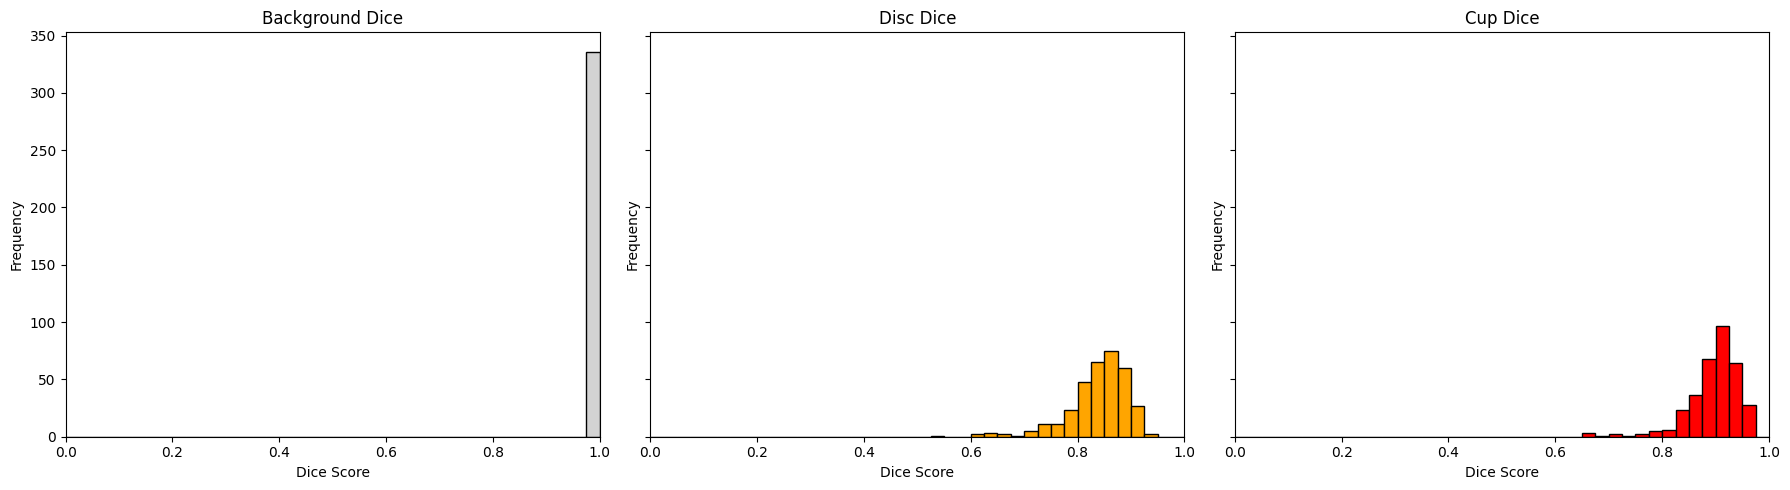

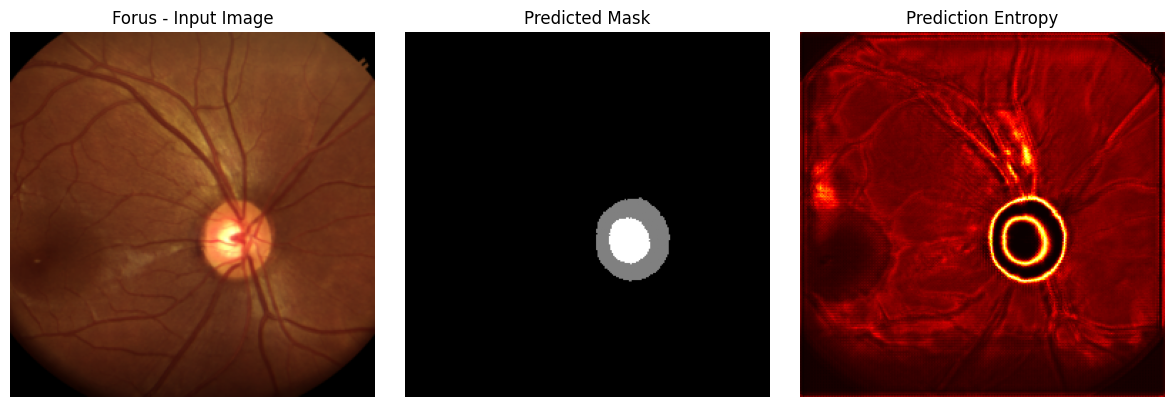

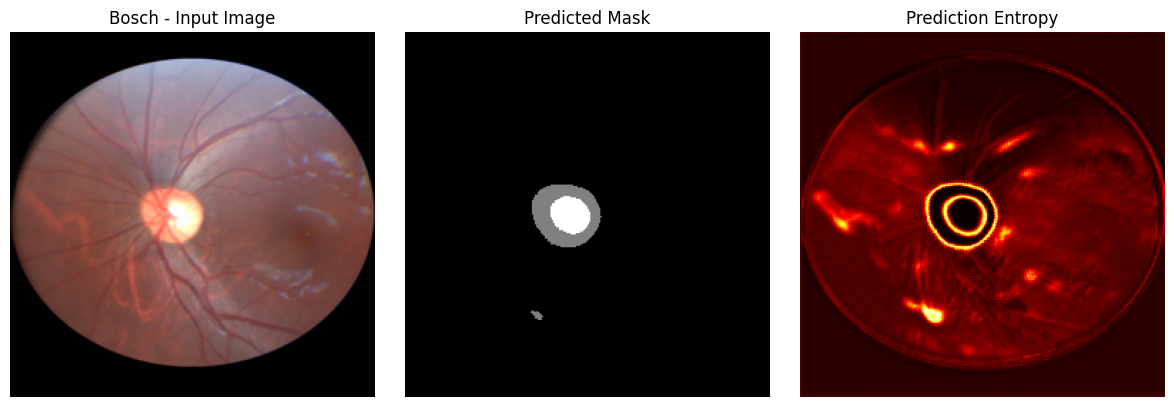

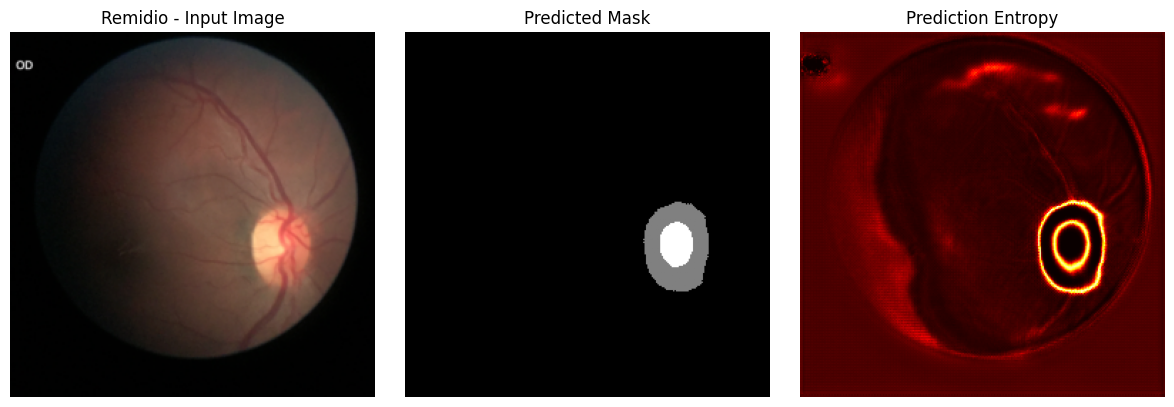

In [ ]:
mix_test_df = evaluate_multi_unc_model_df(mix_model, test_loader_all, T=5, num_classes=3)
mix_test_df.to_csv('mix_test_df.csv', index=False)
plot_dice_hist(mix_test_df)
plot_device_examples_multitask_unc(mix_model, tls, T=5)